# Coupon Purchase Prediction

: Predict which coupons a customer will buy

## Contents

- 프로젝트 소개

- 데이터 소개

- EDA

- Modeling

- Evaluation

---

## 1. 프로젝트 소개

### 1.1 목표

: 고객들이 어떤 쿠폰을 구입할지 예측하는 문제

### 1.2 Ponpare

1. 일본 소셜커머스 사이트
2. 음식, 숙박, 미용 등 다양한 분야의 쿠폰을 판매하는 기업

### 1.3 채점 방식

- MAP (Mean Average Precision) 방식

$$MAP@10 = \frac{1}{|U|} \sum_{u=1}^{|U|} \frac{1}{min(m, 10)} \sum_{k=1}^{min(n,10)} P(k)$$

### 1.4 결과

1. 기간 : 15/07/16 - 15/09/24
2. 참가 : 총 1,076팀
3. 점수 : 0.006385
4. 결과 : 등/1076팀 (상위 %)

---

## 2. 데이터 소개

### 2.1 구조 설명

<img src="img/erd.PNG">

1. User_list, Coupon_area_train/test, Coupon_list_train/test, Coupon_visit_train, Coupon_detail_train, Prefecture_locations 등 총 8개의 파일 데이터가 주어짐
2. 일본어로 이루어진 데이터가 존재 (Translation필요)
3. 고객지역, 쿠폰의 가게 지역의 위도, 경도 데이터가 있는데, 이는 각 지역에 단순히 위도, 경도만을 추가한 것임

#### Note : 

1. 데이터는 크게 User(고객), Visit or Detail (조회, 구매로그), Coupon (쿠폰)으로 나누어짐
2. 데이터 구조가 고객과 쿠폰을 이어주는 연결고리가 조회, 구매로그임을 확인 할 수 있음
3. 이를 통해 데이터가 여러개로 나뉘어져 있어 하나로 통합할 필요성이 있음

### 2.2 Feature 선정

### 2.3 종속변수 선정

---

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib as mpl
import matplotlib.pylab as plt
import seaborn as sns
from datetime import datetime
sns.set()
sns.set_style("whitegrid")
sns.set_color_codes()
from sklearn.preprocessing import Imputer

## 3. EDA

: EDA의 목적은 Feature에 적합한 Column들을 찾는 것

### 3.1 User_list

: 고객에 대한 정보가 들어있는 파일

#### 3.1.1 Data_load

In [2]:
user_list = pd.read_csv('../data/user_list_translated_en.csv', index_col=0)

#### 3.1.2 Overall_EDA

In [3]:
# user_list shape
print("user_list : ", user_list.shape)

user_list :  (22873, 5)


In [4]:
# user_list information
user_list.info()

<class 'pandas.core.frame.DataFrame'>
Index: 22873 entries, 2012.3.28 14:14 to 2011.2.24 15:43
Data columns (total 5 columns):
SEX_ID           22873 non-null object
AGE              22873 non-null int64
WITHDRAW_DATE    922 non-null object
PREF_NAME        15617 non-null object
USER_ID_hash     22873 non-null object
dtypes: int64(1), object(4)
memory usage: 1.0+ MB


In [17]:
# Unique count
for i in range(0, 5):
    print('{} : {}'.format(user_list.columns[i], len(set(user_list[user_list.columns[i]]))))

SEX_ID : 2
AGE : 66
WITHDRAW_DATE : 904
PREF_NAME : 48
USER_ID_hash : 22873


#### 3.1.3 PREF_NAME

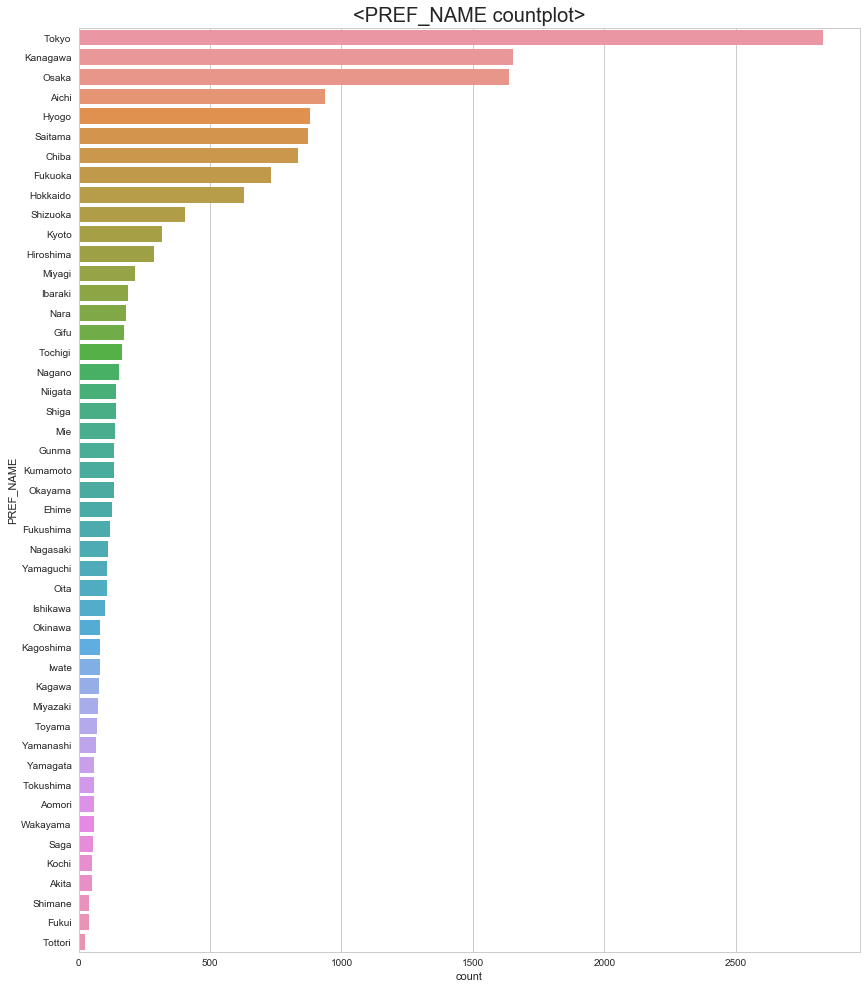

In [18]:
# PREF_NAME countplot 
plt.figure(figsize=(14, 17))
sns.countplot(y = user_list['PREF_NAME'], data = user_list, order = user_list['PREF_NAME'].value_counts().index)
plt.title("<PREF_NAME countplot>", fontsize = 20)

plt.show()

In [5]:
# PREF_NAME counts
pref_name = user_list.groupby("PREF_NAME").size().reset_index(name='counts')
pref_name = pref_name.sort_values(by=['counts'], ascending=False)
pref_name = pref_name.reset_index(drop=True)
pref_name.head()

,PREF_NAME,counts
0,Tokyo,2830
1,Kanagawa,1653
2,Osaka,1638
3,Aichi,938
4,Hyogo,879


#### Note :

1. Tokyo(도쿄), Kanagawa Prefecture(가나가와 현), Osaka Prefecture(오사카 현) 등이 다른 현에 비해 두드러지게 큼
2. 지역별 가입 편차가 큼 

### 3.2 Coupon_list

: 쿠폰별 다양한 정보 ( 장르 / 가격 / 기간 / 지역 )

#### 3.2.1 Data_load

In [6]:
coupon_list = pd.read_csv('../data/coupon_list_train_translated_en.csv', index_col=0)

#### 3.2.2 Overall EDA

In [7]:
# coupon_list shape
print("coupon_list : ", coupon_list.shape)

coupon_list :  (19413, 23)


In [8]:
# coupon_list information
coupon_list.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19413 entries, Food to Food
Data columns (total 23 columns):
GENRE_NAME                    19413 non-null object
PRICE_RATE                    19413 non-null int64
CATALOG_PRICE                 19413 non-null int64
DISCOUNT_PRICE                19413 non-null int64
DISPFROM                      19413 non-null object
DISPEND                       19413 non-null object
DISPPERIOD                    19413 non-null int64
VALIDFROM                     13266 non-null object
VALIDEND                      13266 non-null object
VALIDPERIOD                   13266 non-null float64
USABLE_DATE_MON               19413 non-null int64
USABLE_DATE_TUE               19413 non-null int64
USABLE_DATE_WED               19413 non-null int64
USABLE_DATE_THU               19413 non-null int64
USABLE_DATE_FRI               19413 non-null int64
USABLE_DATE_SAT               19413 non-null int64
USABLE_DATE_SUN               19413 non-null int64
USABLE_DATE_HOLIDAY 

In [22]:
# Unique count
for i in range(0, 23):
    print('{} : {}'.format(coupon_list.columns[i], len(set(coupon_list[coupon_list.columns[i]]))))

GENRE_NAME : 13
PRICE_RATE : 71
CATALOG_PRICE : 2415
DISCOUNT_PRICE : 1115
DISPFROM : 378
DISPEND : 373
DISPPERIOD : 18
VALIDFROM : 377
VALIDEND : 515
VALIDPERIOD : 6327
USABLE_DATE_MON : 2
USABLE_DATE_TUE : 2
USABLE_DATE_WED : 2
USABLE_DATE_THU : 2
USABLE_DATE_FRI : 2
USABLE_DATE_SAT : 2
USABLE_DATE_SUN : 2
USABLE_DATE_HOLIDAY : 2
USABLE_DATE_BEFORE_HOLIDAY : 2
LARGE_AREA_NAME : 9
ken_name : 47
SMALL_AREA_NAME : 55
COUPON_ID_hash : 19413


#### 3.2.3 CAPSULE_TEXT

In [9]:
# CAPSULE_TEXT countplot
plt.figure(figsize=(17, 14))
sns.countplot(y = coupon_list['CAPSULE_TEXT'], data = coupon_list, order = coupon_list['CAPSULE_TEXT'].value_counts().index)
plt.title("<CAPSULE_TEXT countplot>", fontsize = 20)

plt.show()

KeyError: 'CAPSULE_TEXT'

#### Note :

1. CAPSULE_TEXT는 총 24개의 종류를 가지고 있음
2. Delivery service, Food, Hotel 순으로 높았음
3. Delivery, Food 쿠폰이 전체 쿠폰 중 약 절반 (48%)를 차지함
3. Delivery service가 압도적으로 높음

#### 3.2.4 PRICE_RATE 

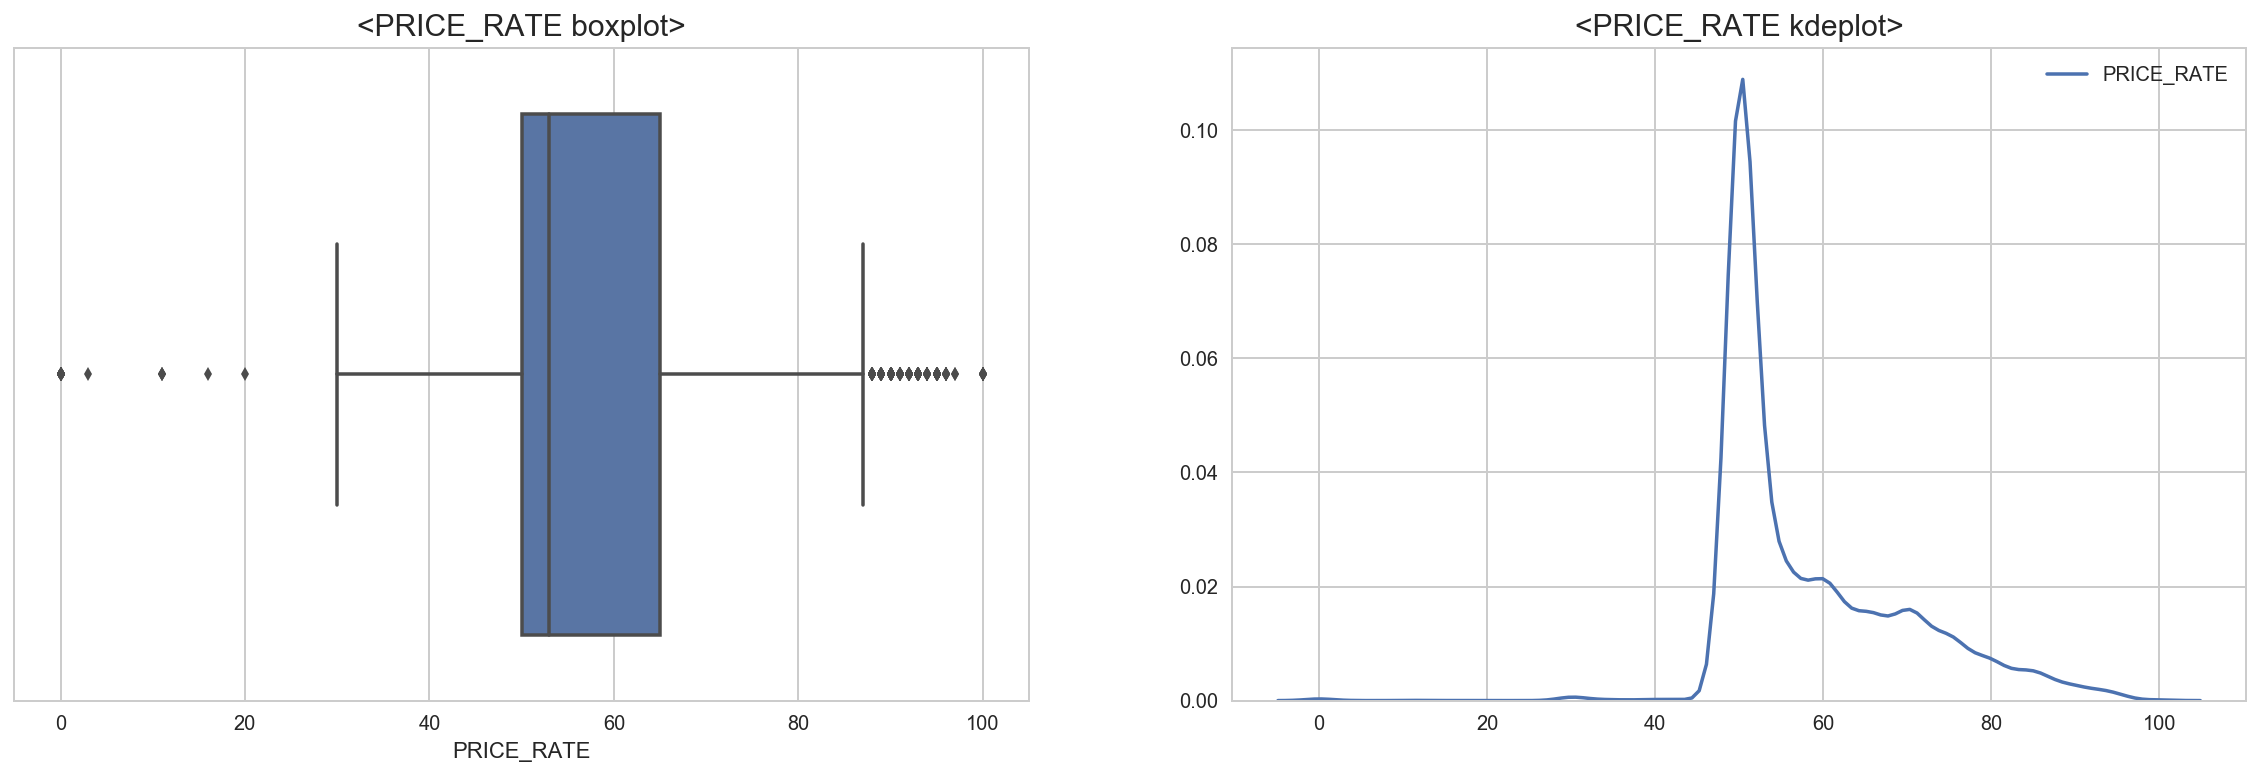

In [13]:
plt.figure(figsize=(20, 6))

# PRICE_RATE Boxplot
plt.subplot(1,2,1)
sns.boxplot(coupon_list['PRICE_RATE'])
plt.title("<PRICE_RATE boxplot>", fontsize = 15)

# PRICE_RATE distplot
plt.subplot(1,2,2)
sns.kdeplot(coupon_list['PRICE_RATE'])
plt.title("<PRICE_RATE kdeplot>", fontsize = 15)

plt.show()

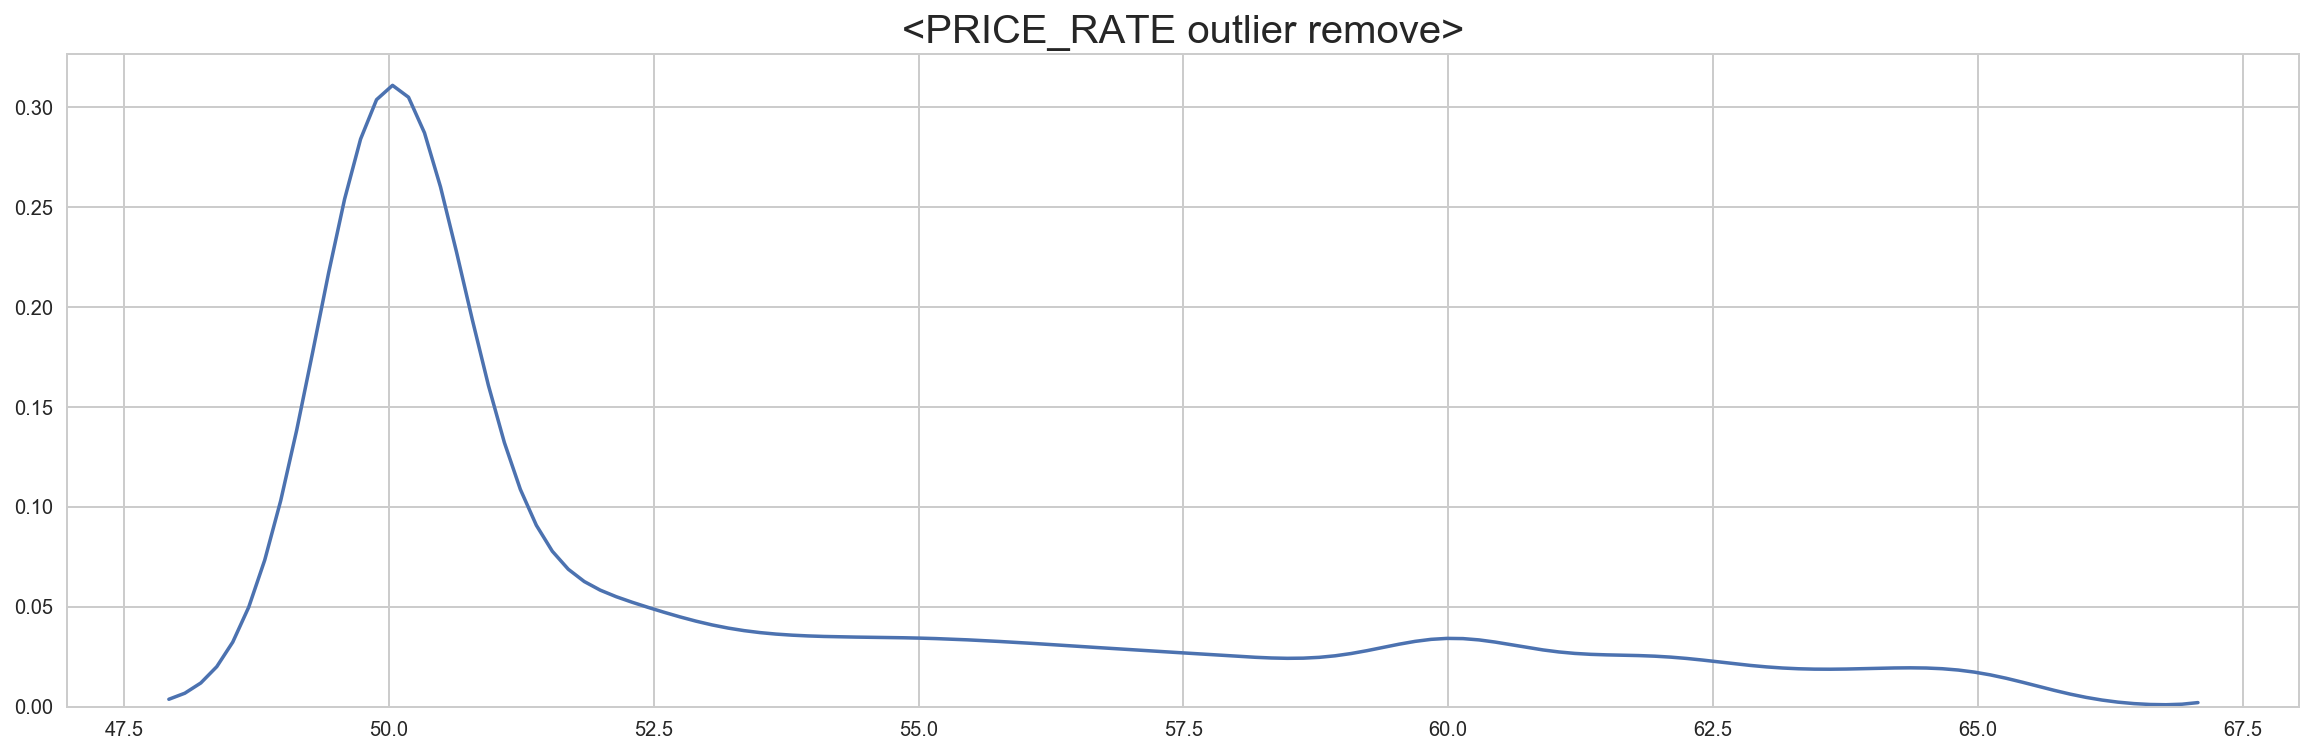

In [14]:
plt.figure(figsize=(20, 6))
plt.title("<PRICE_RATE outlier remove>", fontsize = 20)
tmp = coupon_list['PRICE_RATE']

# tmp.name='QUANTILE'
no_out = tmp[(50 <= tmp) & (tmp <= 65)]
ax = sns.kdeplot(no_out)
ax.legend_.remove()

#### 3.2.5 DISCOUNT_PRICE

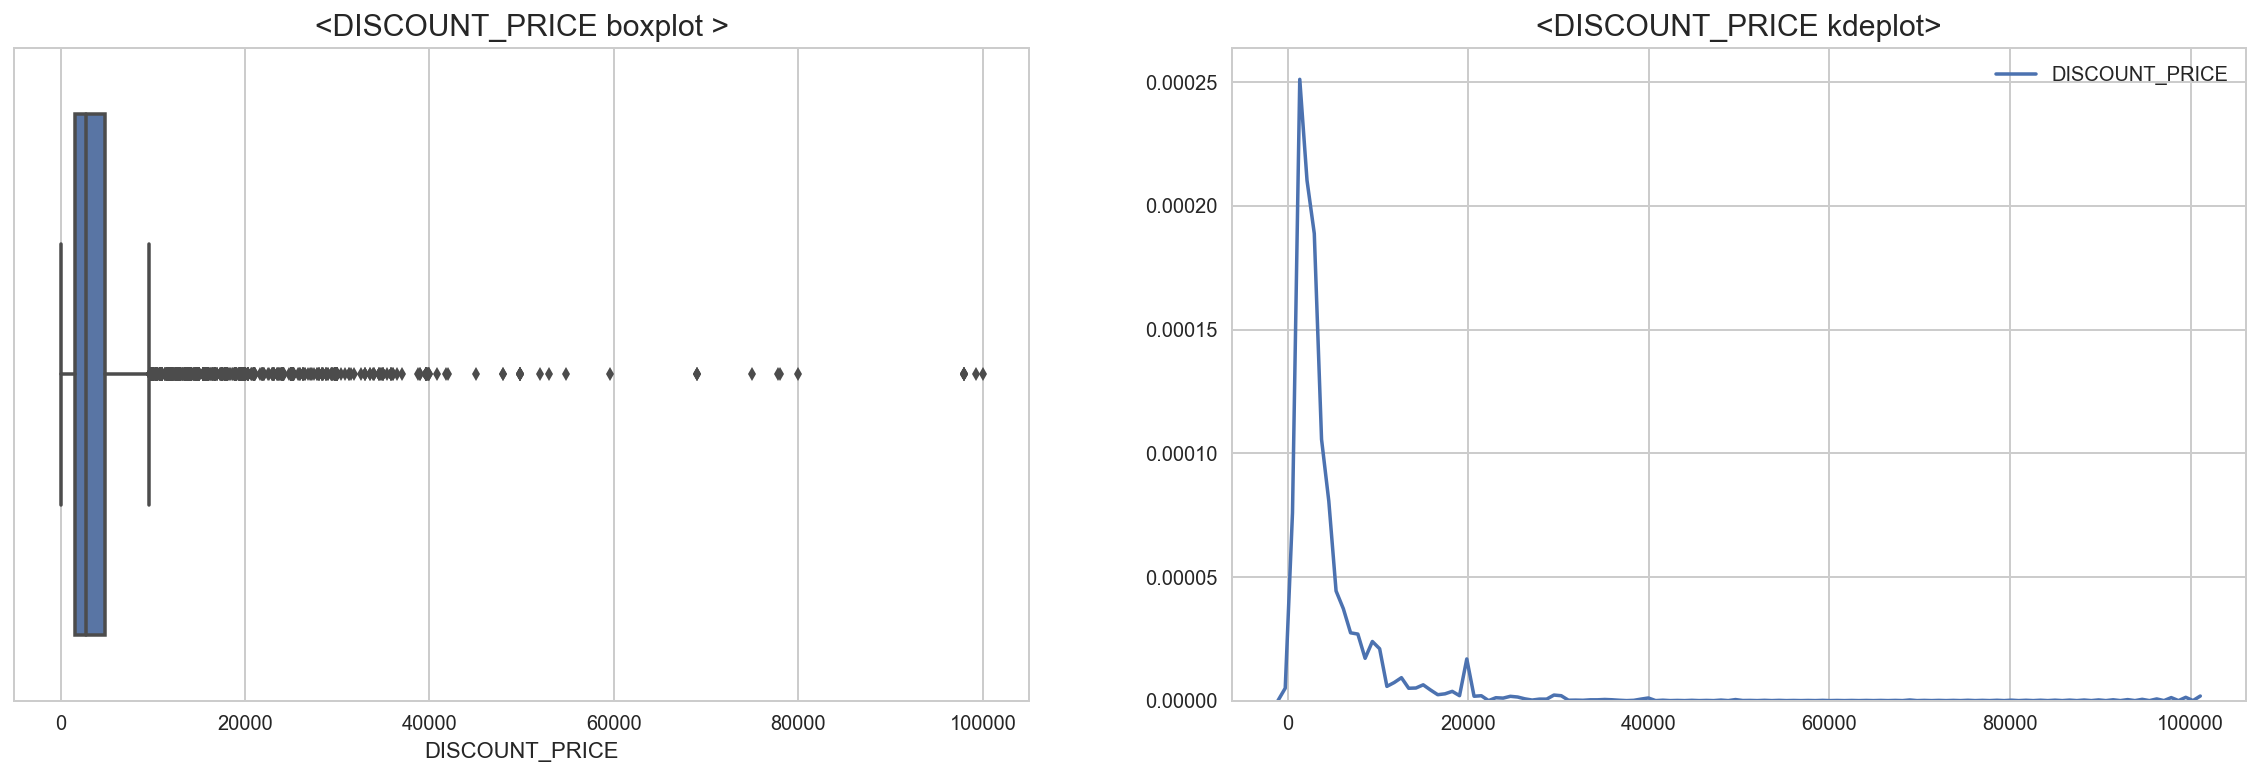

In [15]:
plt.figure(figsize=(20, 6))

# DISCOUNT_PRICE Boxplot
plt.subplot(1,2,1)
sns.boxplot(coupon_list['DISCOUNT_PRICE'])
plt.title("<DISCOUNT_PRICE boxplot >", fontsize = 15)

# DISCOUNT_PRICE distplot
plt.subplot(1,2,2)
sns.kdeplot(coupon_list['DISCOUNT_PRICE'])
plt.title("<DISCOUNT_PRICE kdeplot>", fontsize = 15)

plt.show()

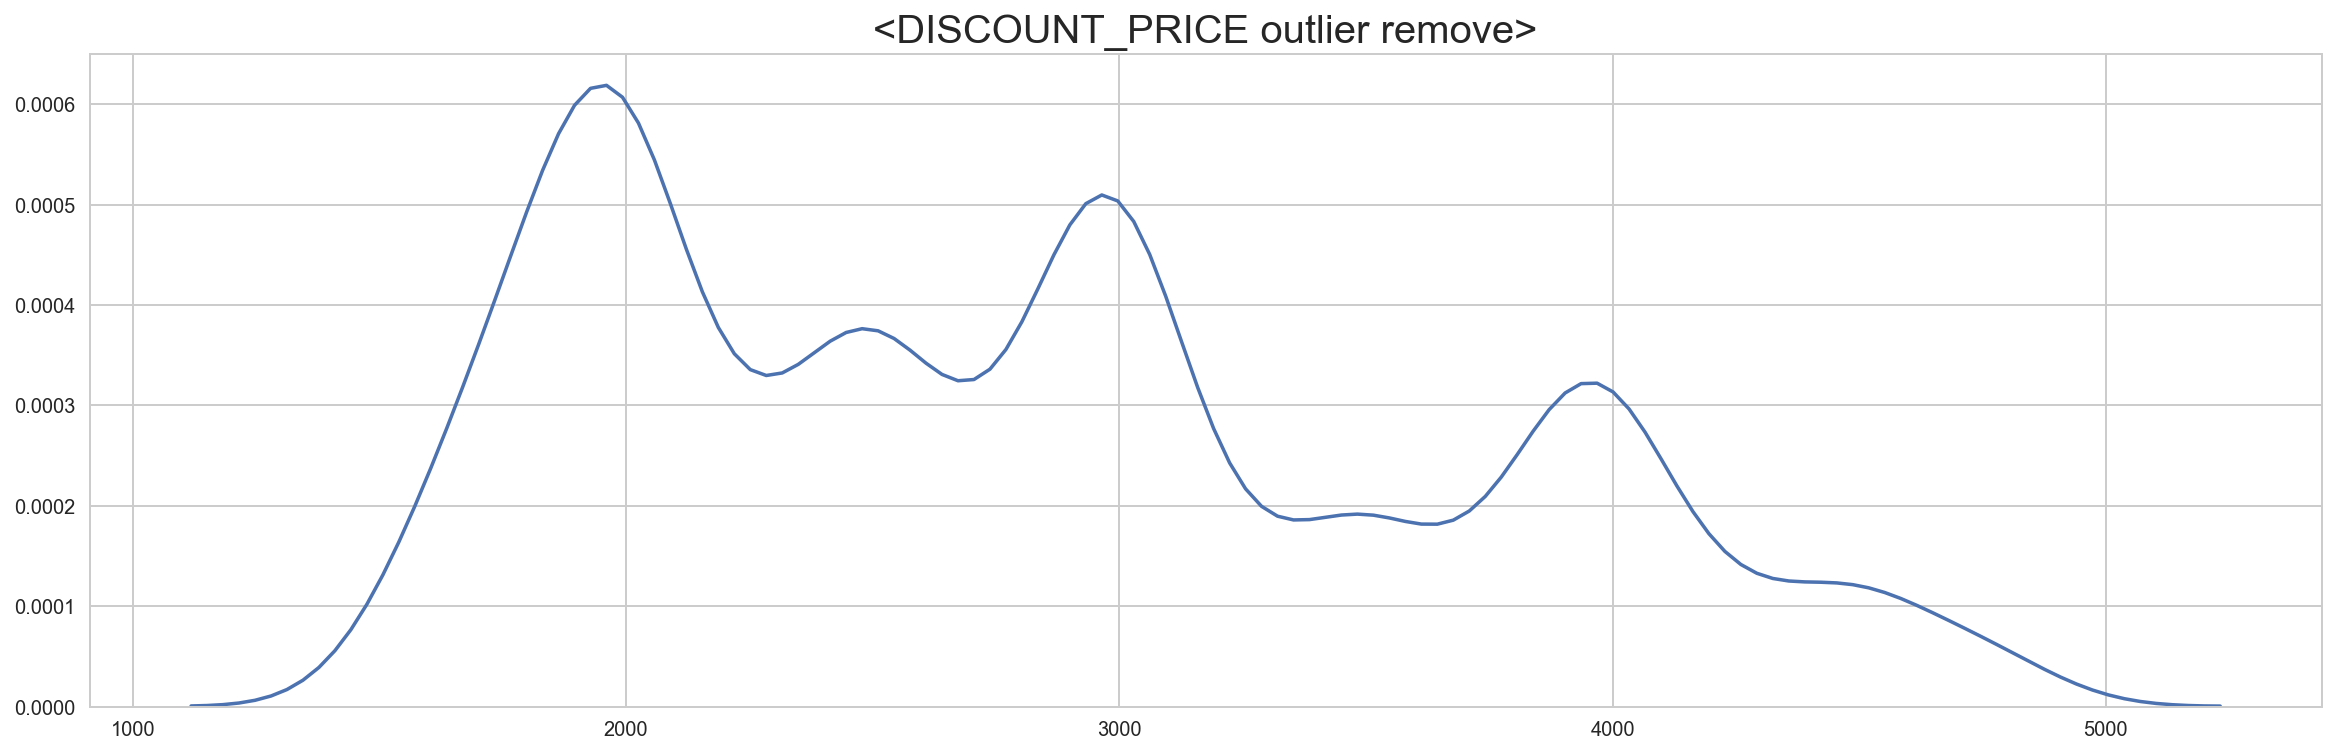

In [16]:
plt.figure(figsize=(20, 6))
plt.title("<DISCOUNT_PRICE outlier remove>", fontsize = 20)
tmp = coupon_list['DISCOUNT_PRICE']

# tmp.name='QUANTILE'
no_out = tmp[(1550<=tmp) & (tmp<=4800)]
ax = sns.kdeplot(no_out)
ax.legend_.remove()

#### Note :

1. 할인가는 2,000엔이 가장 많음

#### 3.2.6 DISPPERIOD

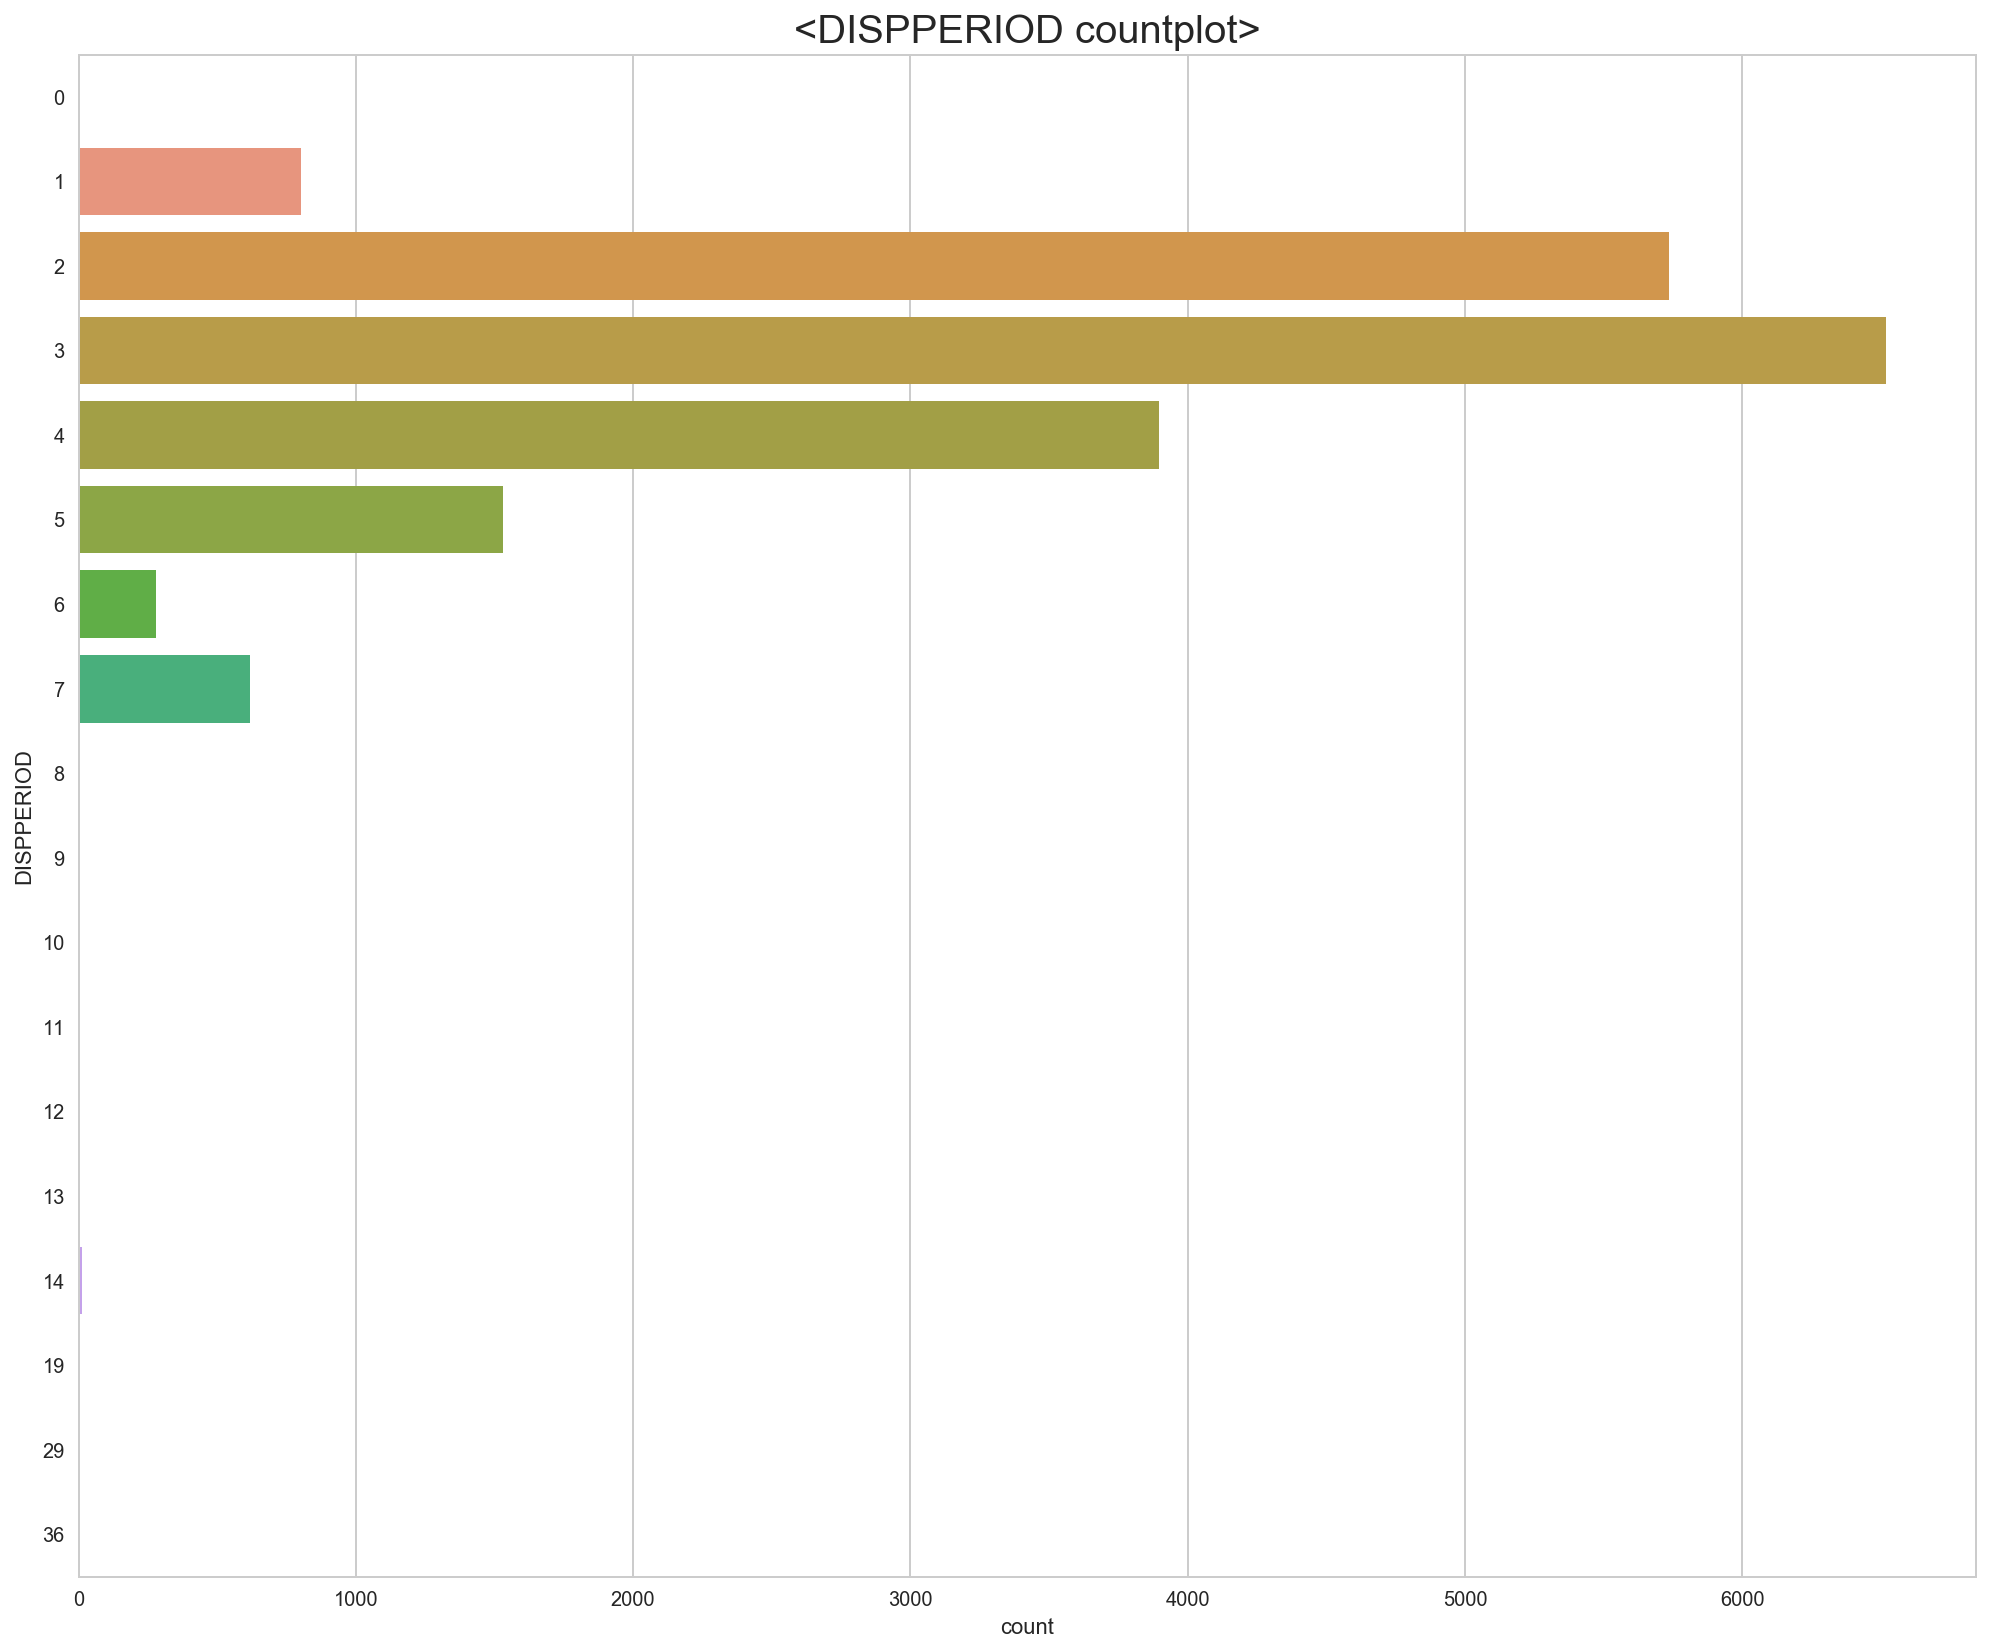

In [17]:
plt.figure(figsize=(17, 14))
sns.countplot(y = 'DISPPERIOD', data = coupon_list)
plt.title("<DISPPERIOD countplot>", fontsize = 20)

plt.show()

#### 3.2.7 VALIDPERIOD

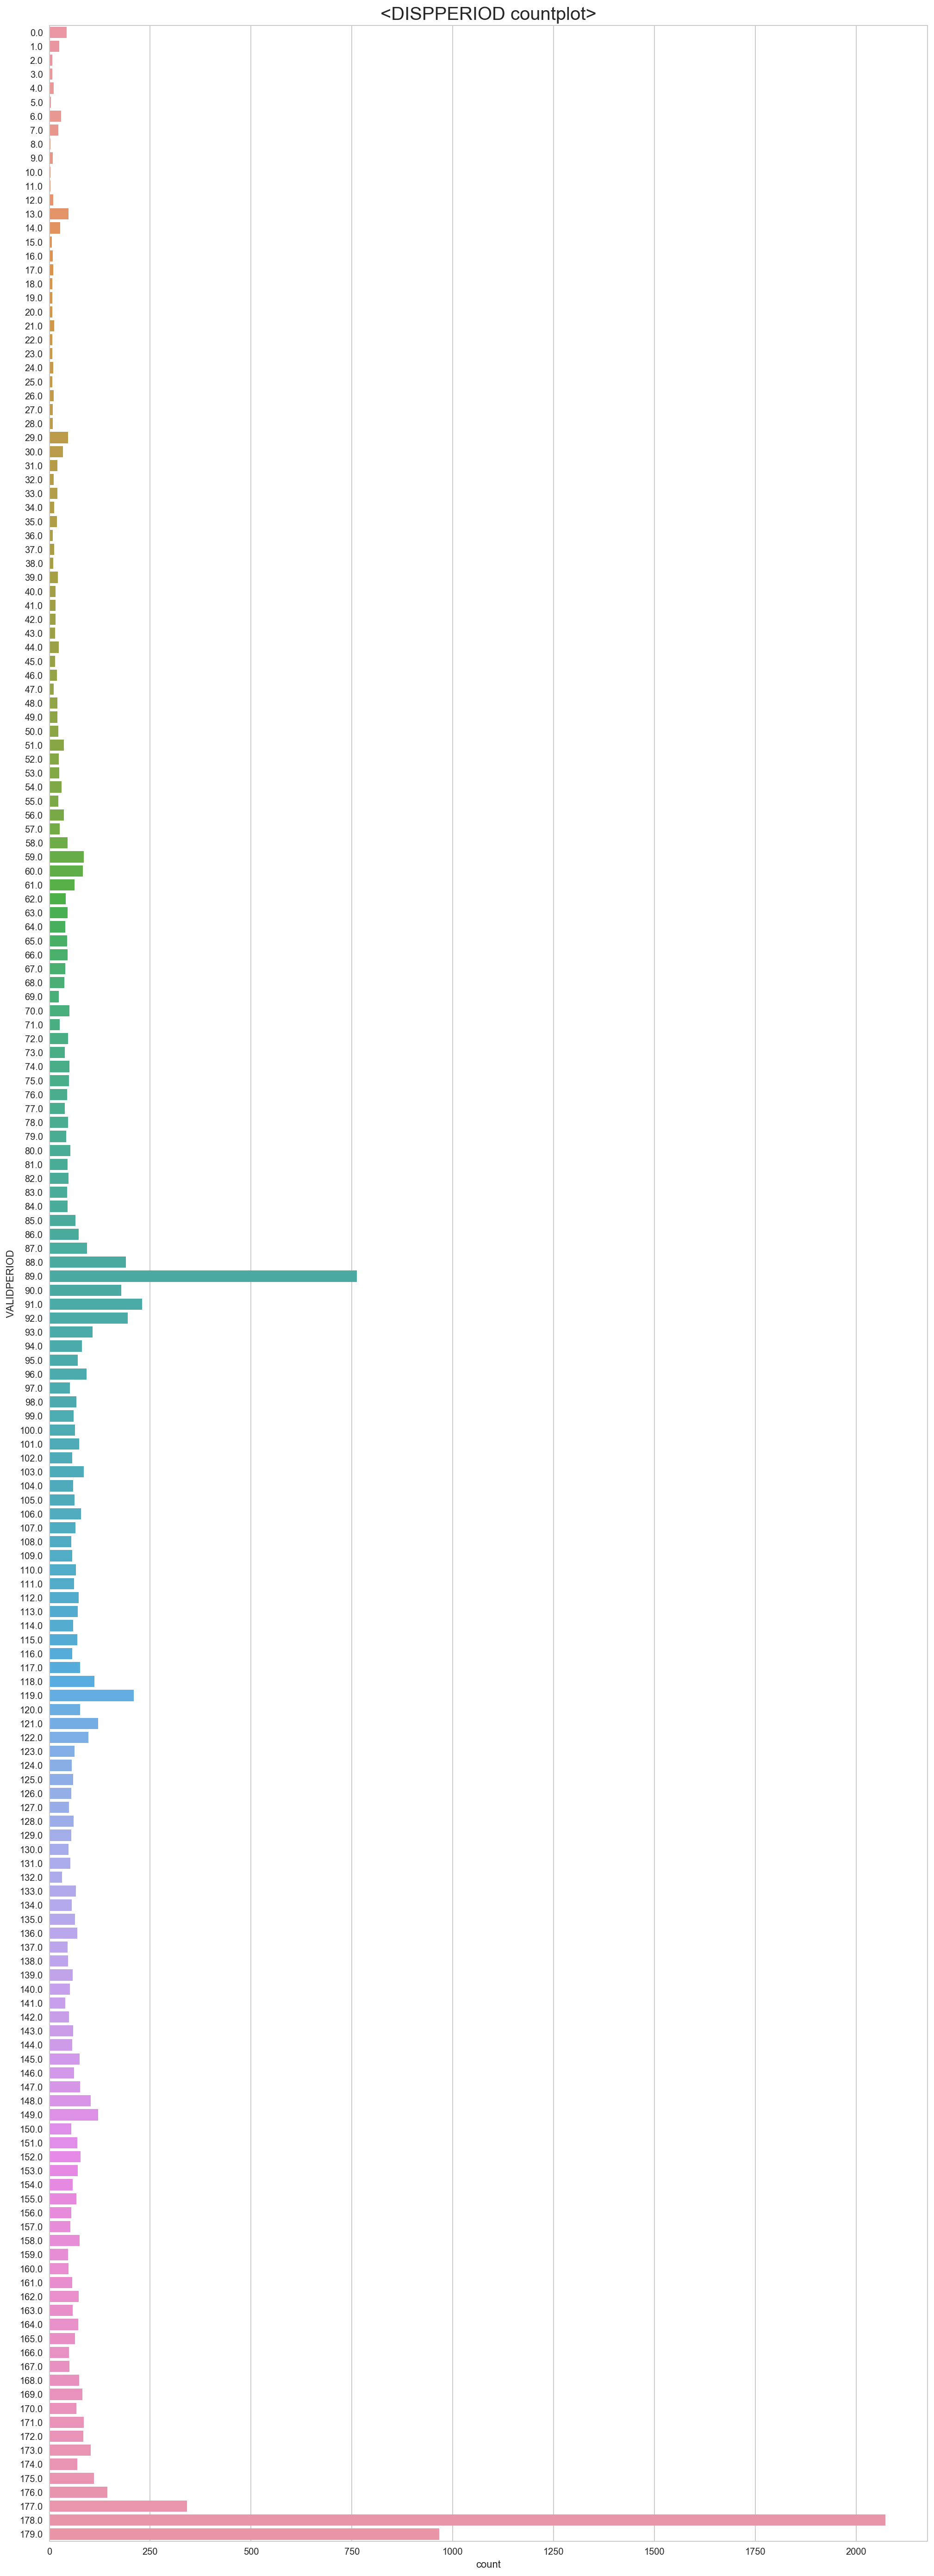

In [18]:
plt.figure(figsize=(17, 50))
sns.countplot(y = 'VALIDPERIOD', data = coupon_list)
plt.title("<DISPPERIOD countplot>", fontsize = 20)

plt.show()

갯수 : 3801


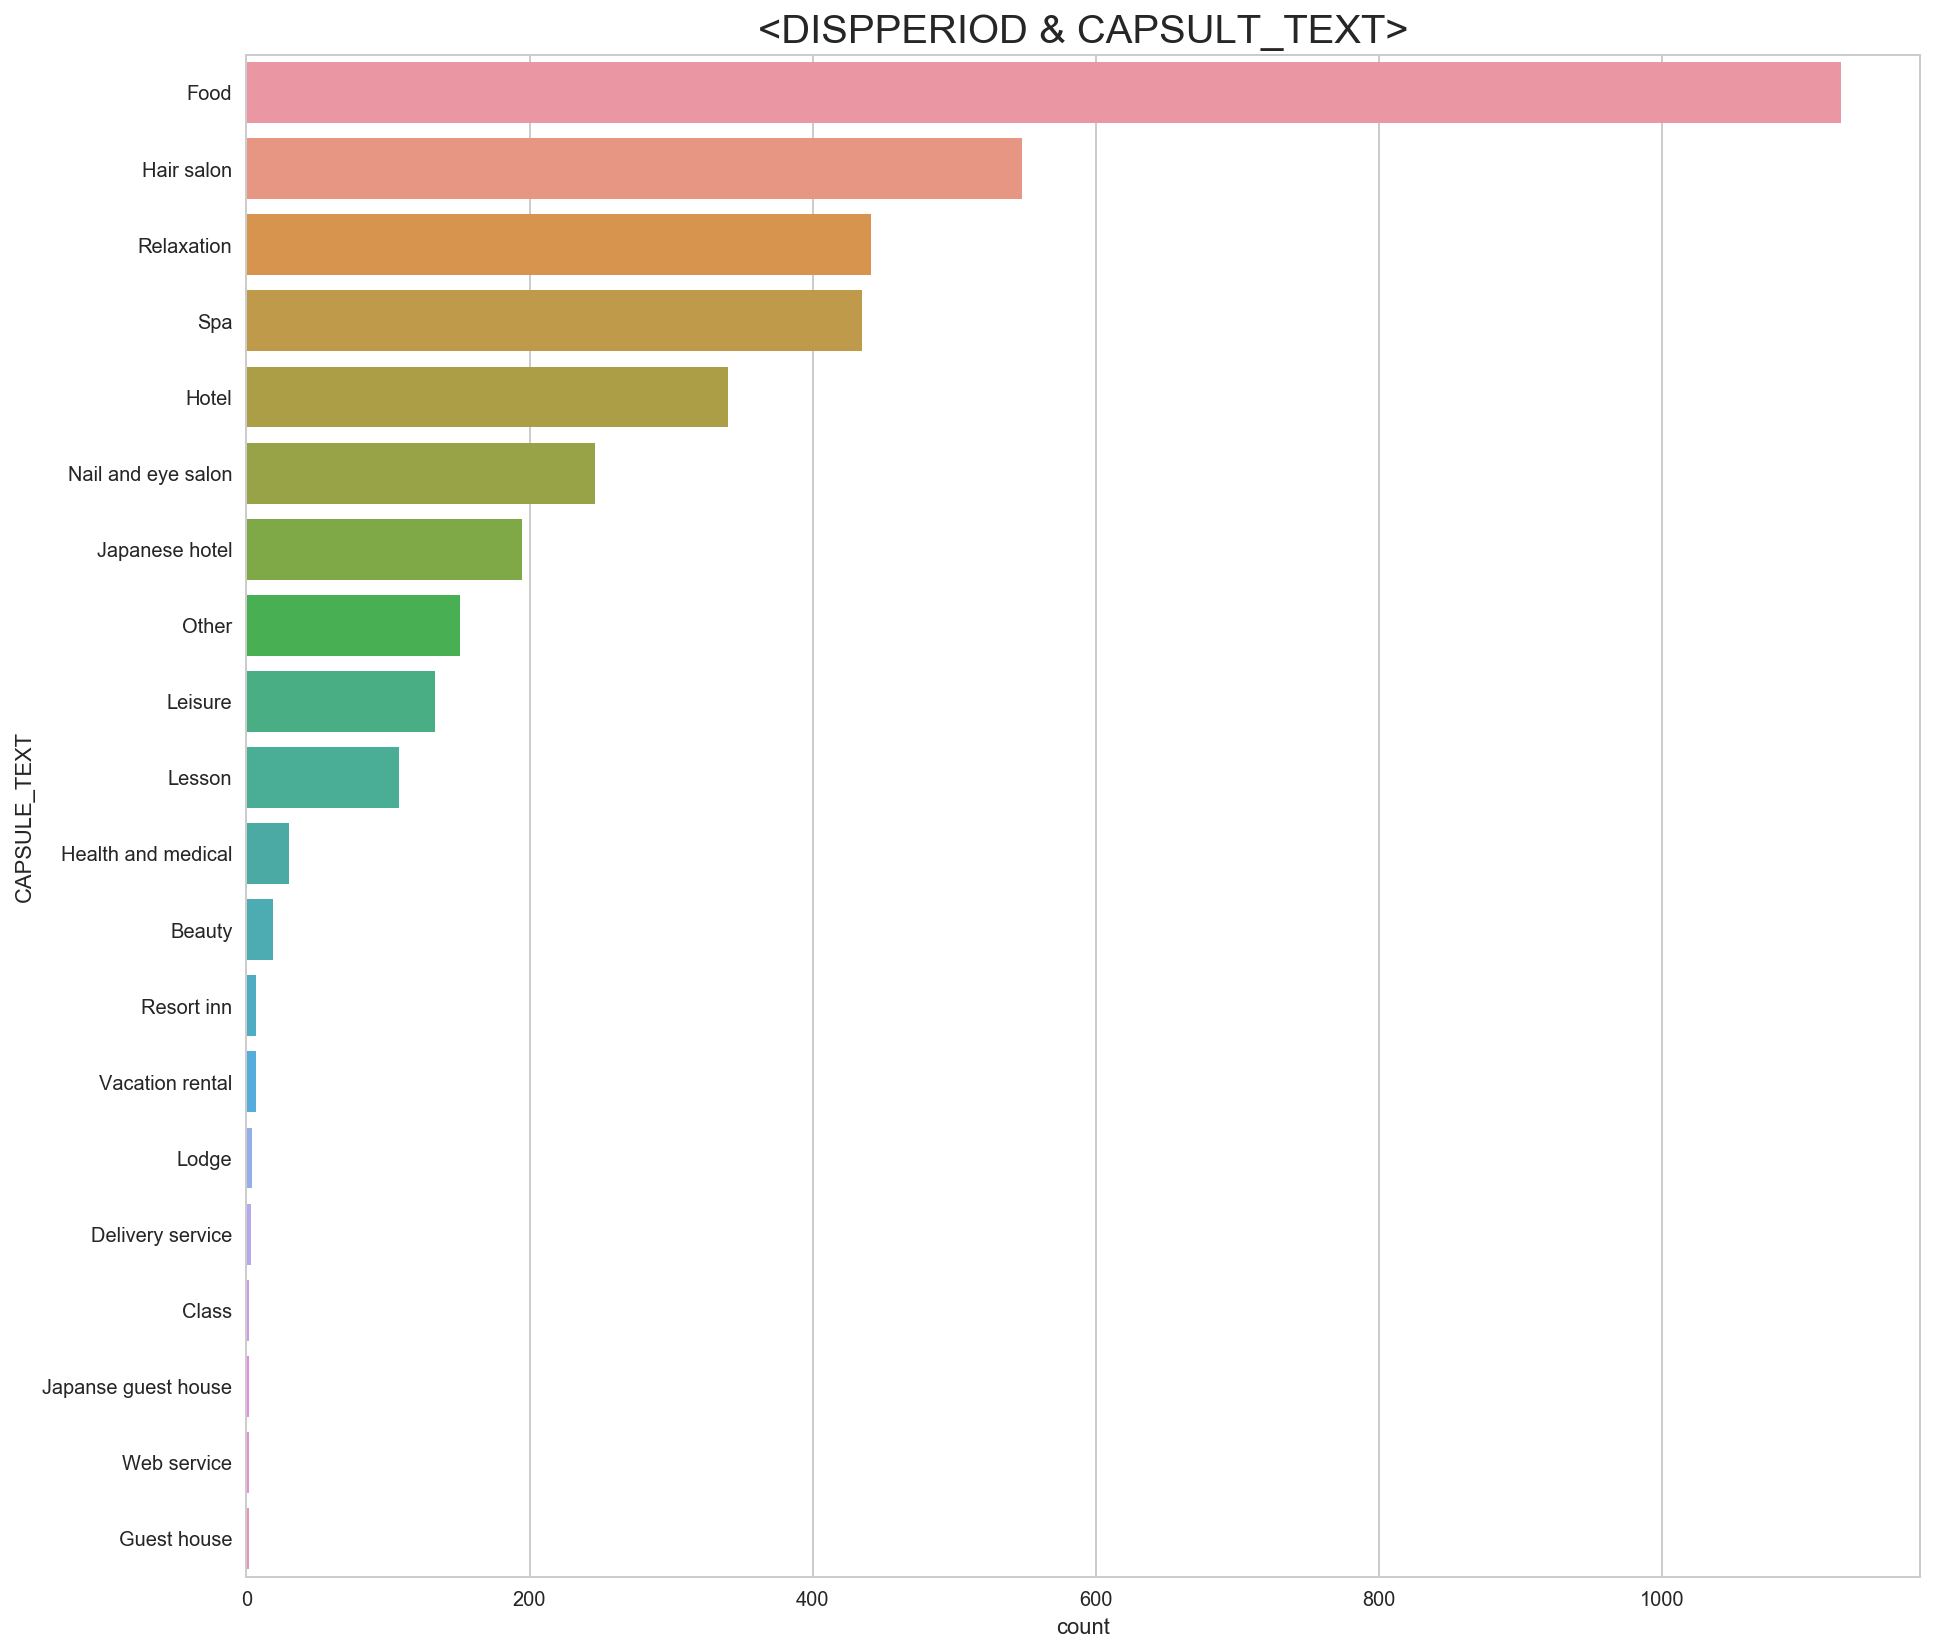

In [19]:
# CAPSULE_TEXT countplot
plt.figure(figsize=(15, 14))
plt.title("<DISPPERIOD & CAPSULT_TEXT>", fontsize = 20)

many = coupon_list['VALIDPERIOD']
many = many[(many == 89) | (many == 179) | (many == 178)]
many_index = many.index
those = coupon_list.loc[many_index, ['CAPSULE_TEXT', 'CATALOG_PRICE']]
print('갯수 : {}'.format(len(many)))

sns.countplot(y = 'CAPSULE_TEXT', data = those,
              order = those['CAPSULE_TEXT'].value_counts().index)

plt.show()

#### Note : 

1. 유효기간 비중이 많은 쿠폰들 중 Food 쿠폰이 가장 많이 팔림

#### 3.2.8 USABLE_DATE

In [9]:
# NaN값을 1로 대체, 2를 1로 대체
for i in range(11, 19+1) :
    coupon_list[coupon_list.columns[i]] = coupon_list[coupon_list.columns[i]].fillna(1)
    coupon_list[coupon_list.columns[i]] = coupon_list[coupon_list.columns[i]].replace(2, 1)

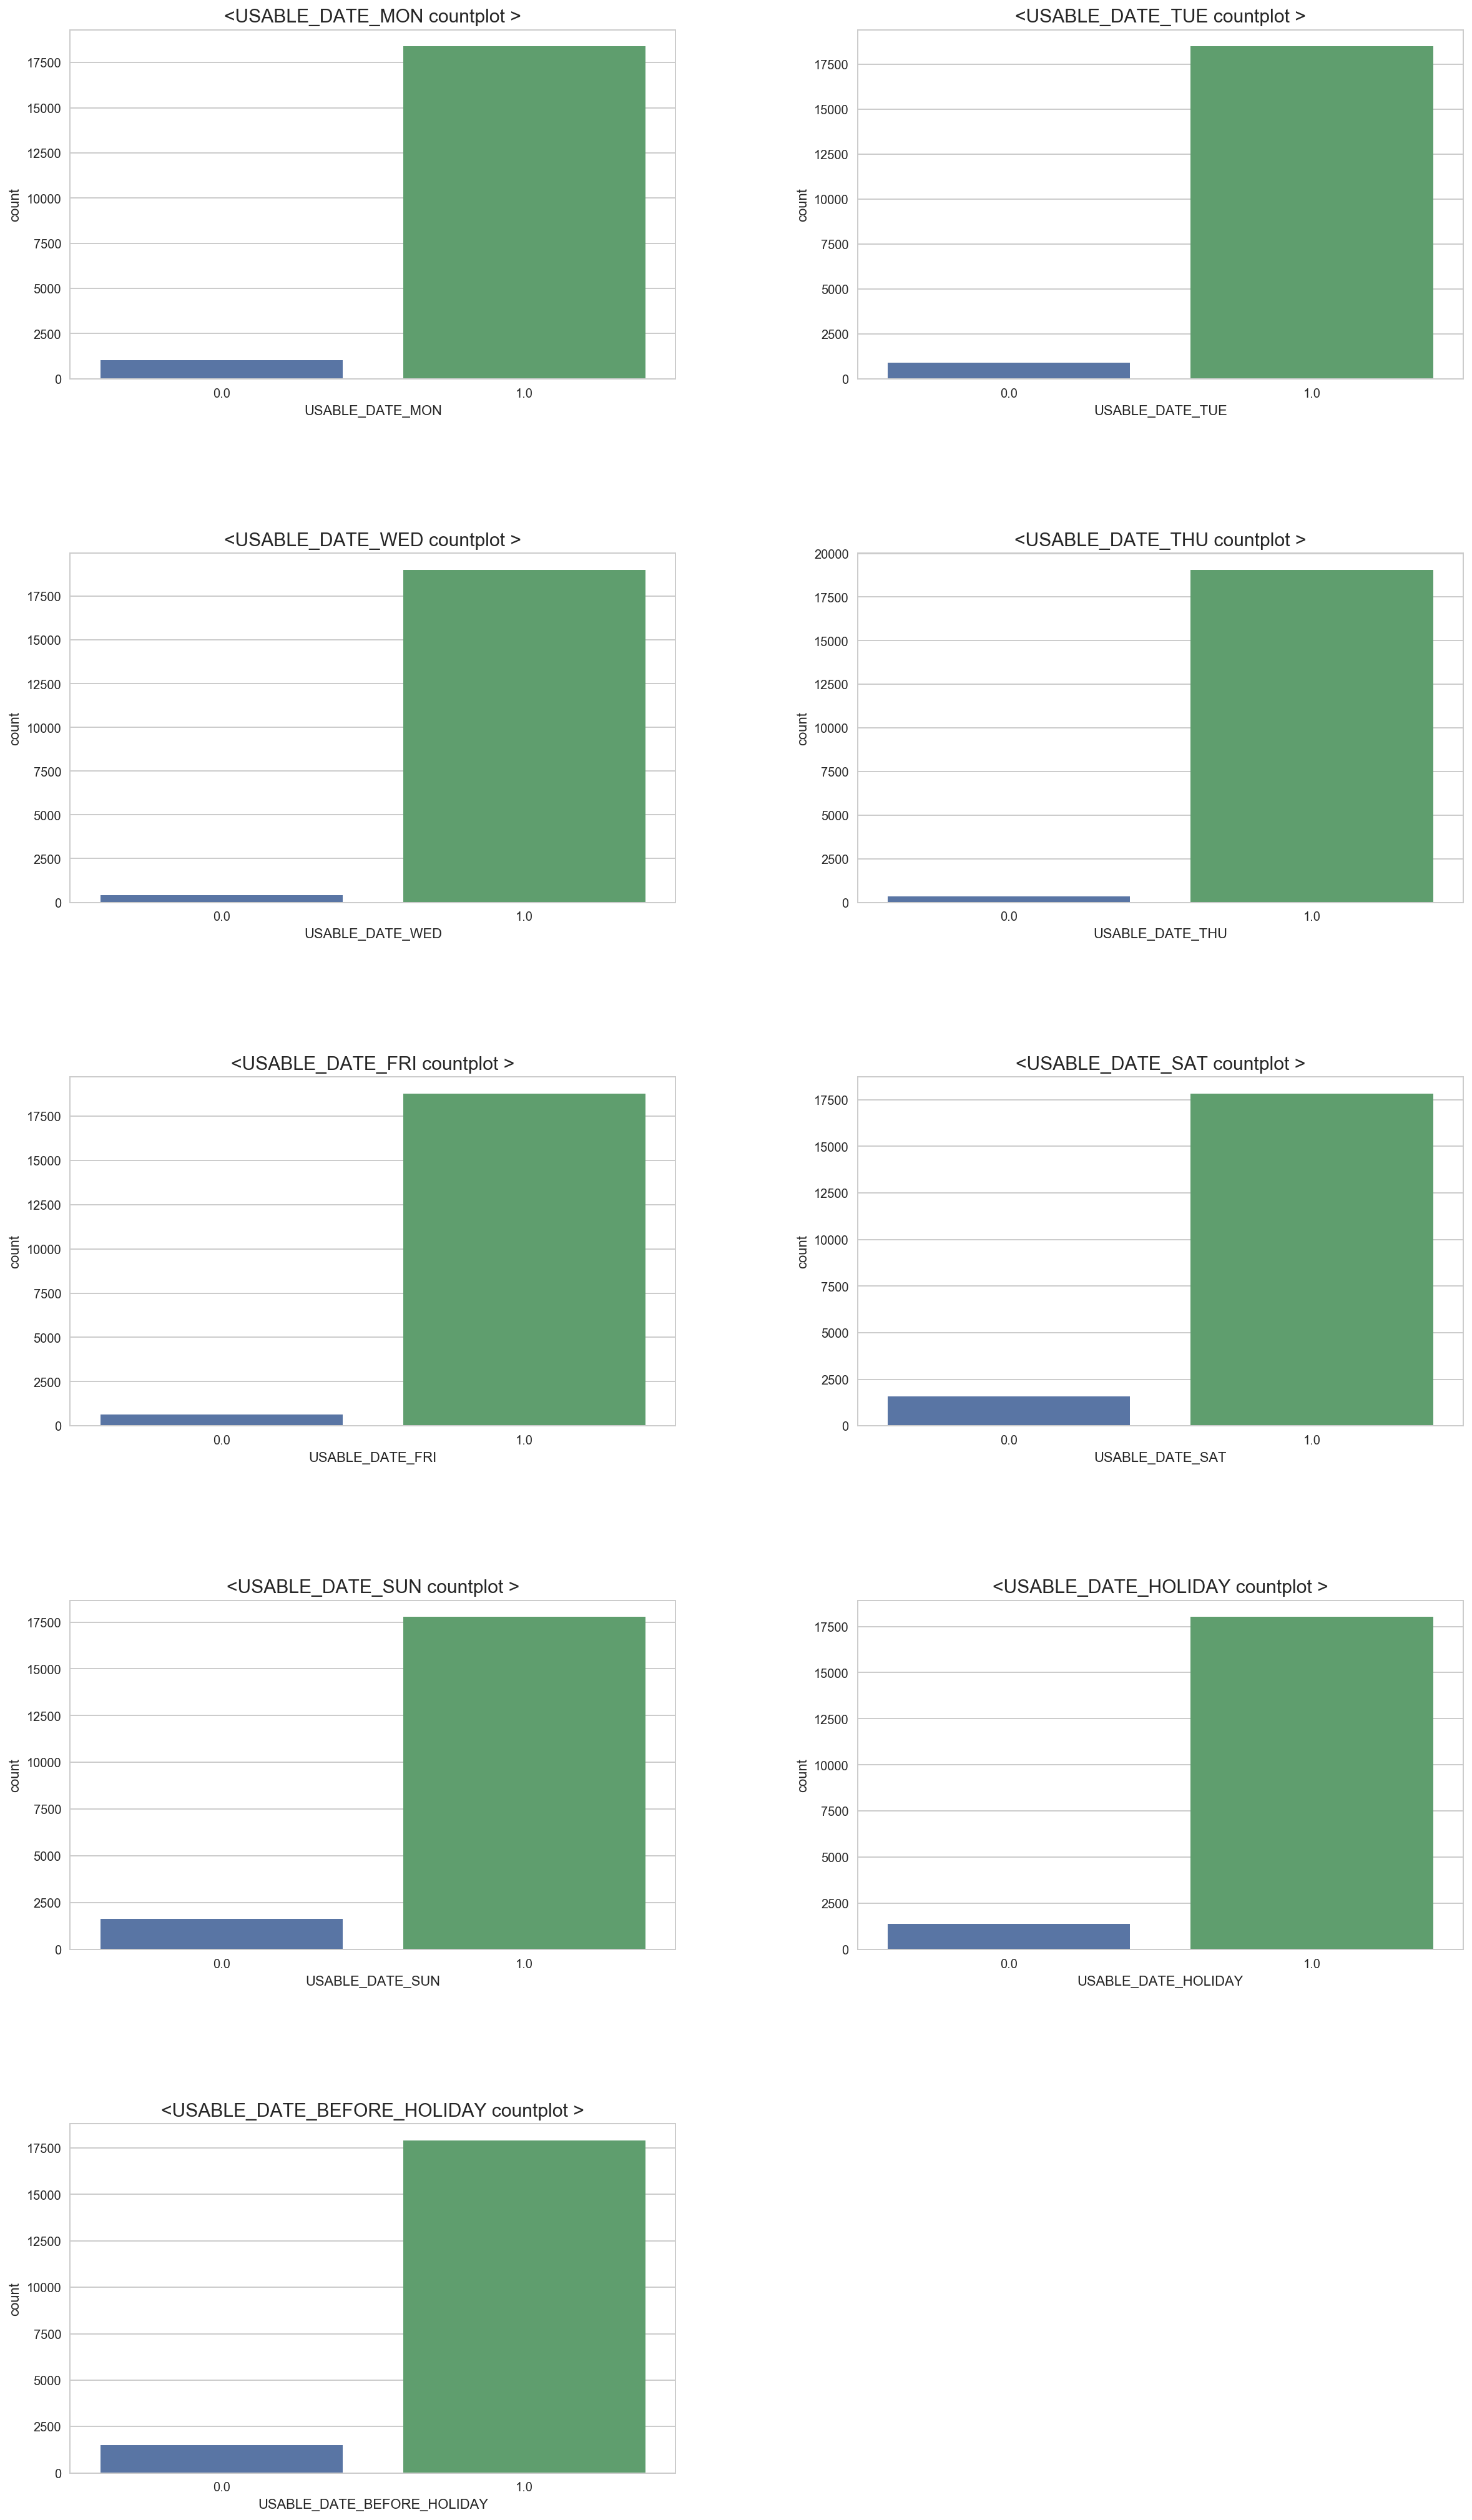

In [21]:
# USABLE_DATE countplot
plt.figure(figsize=(20, 36))
plt.subplots_adjust(hspace = 0.5, wspace = 0.3)

for i in range(11, 19+1):
    plt.subplot(5,2,i-10)
    sns.countplot(x = coupon_list.columns[i], data = coupon_list)
    plt.title("<{} countplot >".format(coupon_list.columns[i]), fontsize = 15)

plt.show()

In [22]:
# 각 요일별 쿠폰중 사용가능 쿠폰 비율

cols = list(coupon_list.columns[11:19+1])
for col in cols:
    tmp = coupon_list[col]
    print(col, len(tmp[tmp == 1]) / 19413, len(tmp[tmp == 1]))

USABLE_DATE_MON 0.9475609127903982 18395
USABLE_DATE_TUE 0.9530726832534899 18502
USABLE_DATE_WED 0.9790861793643435 19007
USABLE_DATE_THU 0.9815587492917117 19055
USABLE_DATE_FRI 0.967444495956318 18781
USABLE_DATE_SAT 0.9187657755112554 17836
USABLE_DATE_SUN 0.9154175037346108 17771
USABLE_DATE_HOLIDAY 0.9279348889919127 18014
USABLE_DATE_BEFORE_HOLIDAY 0.9222170710348735 17903


#### Note : 

1. 주말, 휴일보다 주중에 사용가능한 쿠폰들이 많음
2. 주중에 소비를 유도하기 위해 쿠폰이 사용된 것으로 판단

#### 3.2.9 large_area_name

In [10]:
# large_area_name counts DataFrame
large_area_name = coupon_list.groupby("large_area_name").size().reset_index(name='counts')
large_area_name = large_area_name.sort_values(by=['counts'], ascending=False)
large_area_name = large_area_name.reset_index(drop=True)
large_area_name.head()

KeyError: 'large_area_name'

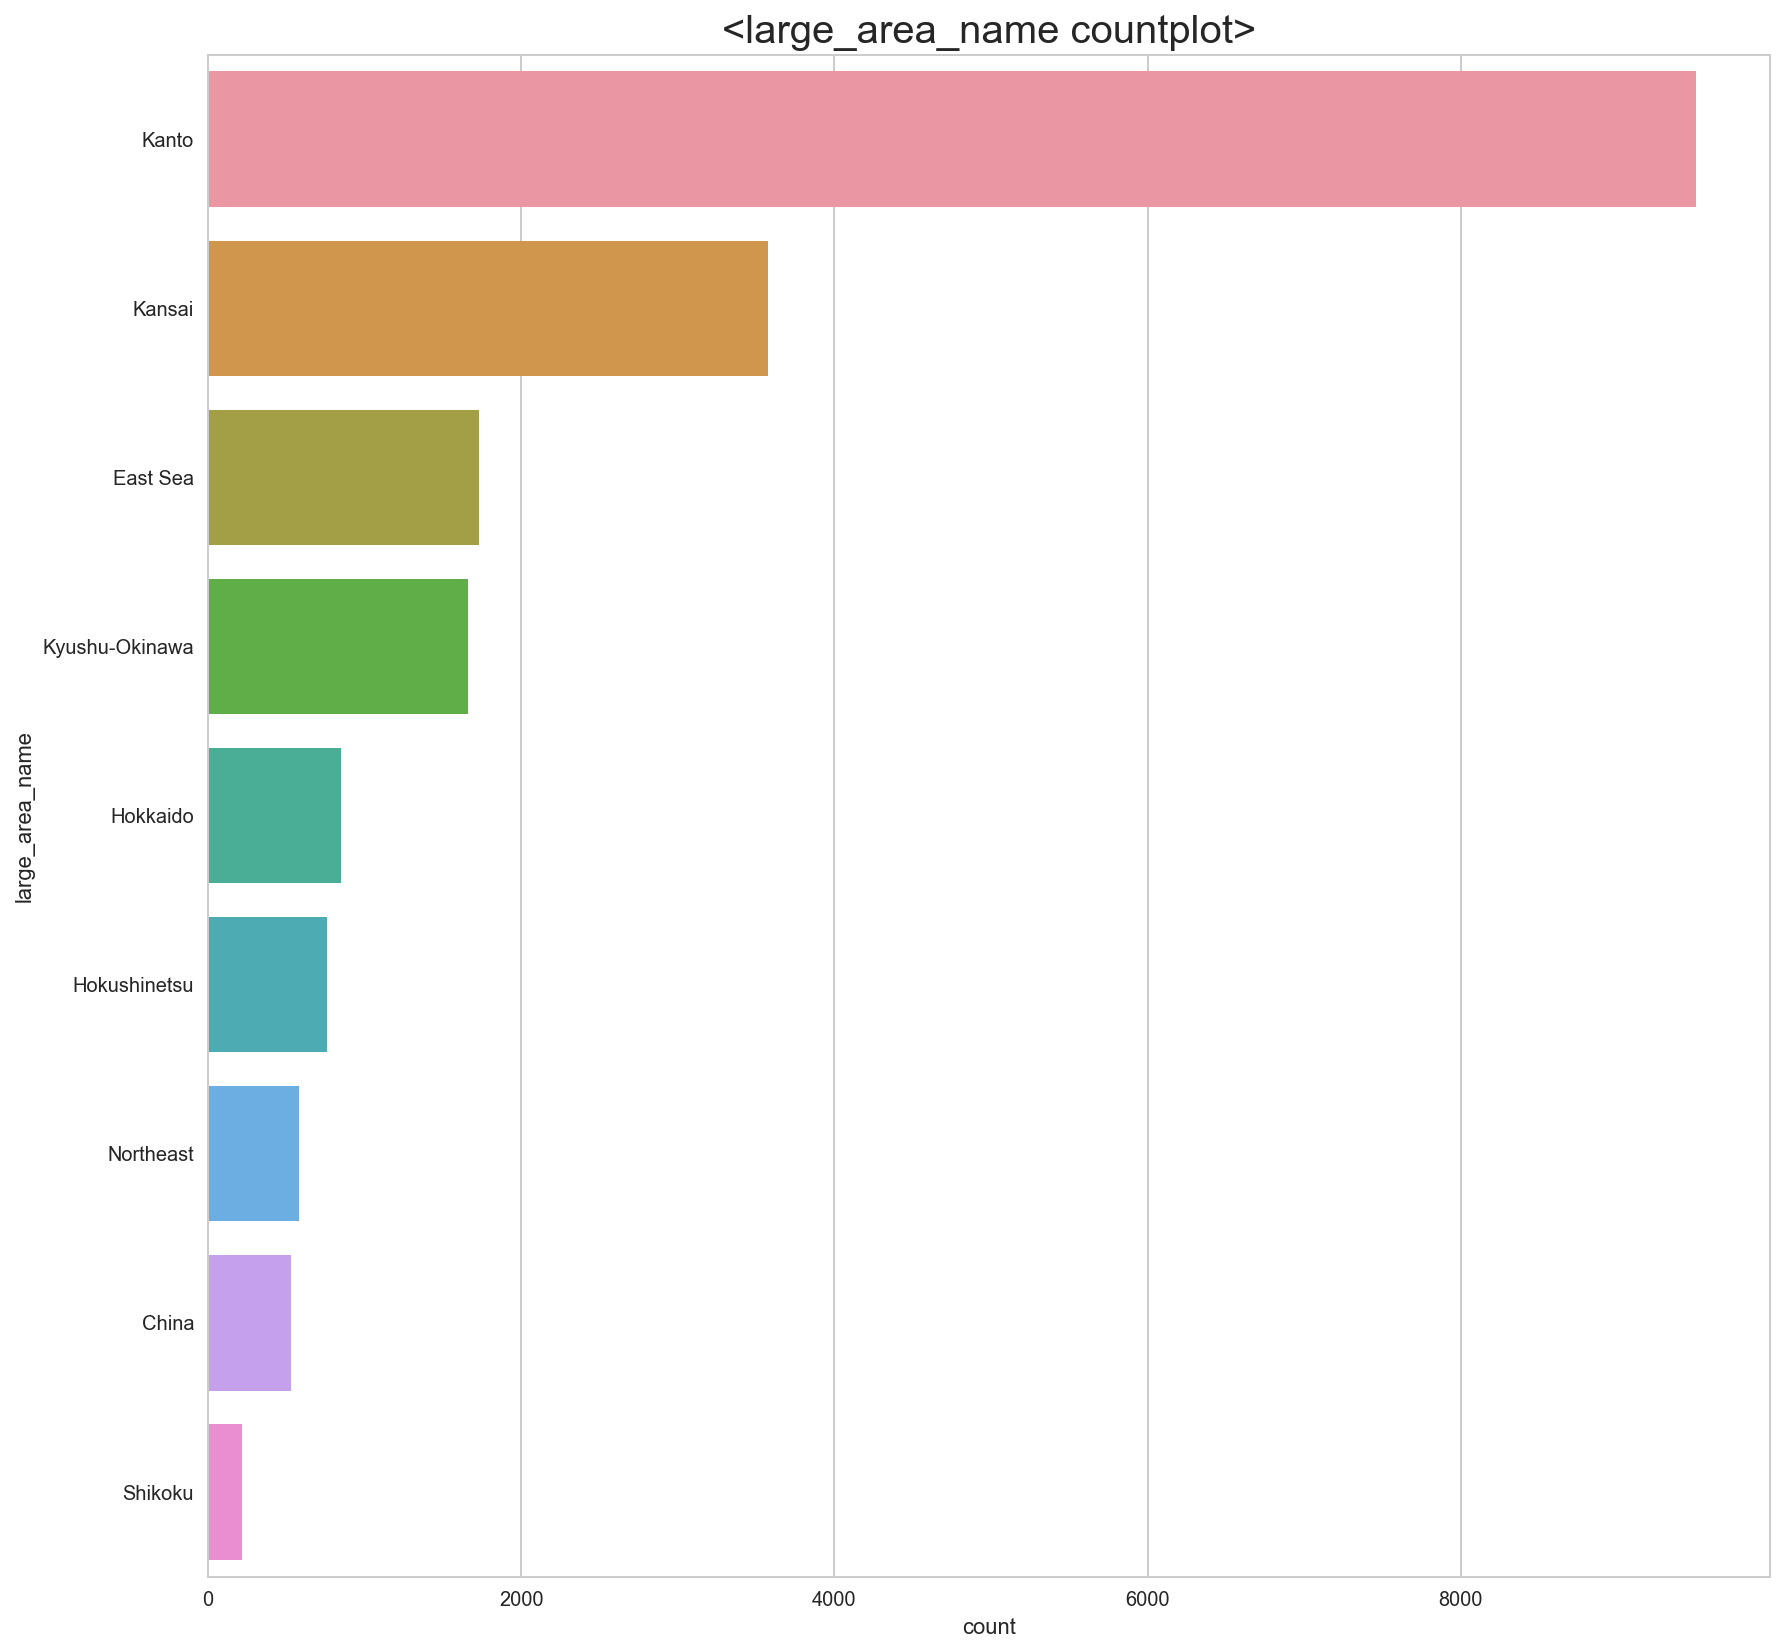

In [24]:
# large_area_name countplot
plt.figure(figsize=(14, 14))
plt.title("<large_area_name countplot>", fontsize = 20)
sns.countplot(y = coupon_list['large_area_name'], data = coupon_list, order = coupon_list['large_area_name'].value_counts().index)

plt.show()

#### 3.2.10 ken_name

In [25]:
# ken_name counts DataFrame
ken_name = coupon_list.groupby("ken_name").size().reset_index(name='counts')
ken_name = ken_name.sort_values(by=['counts'], ascending=False)
ken_name = ken_name.reset_index(drop=True)
ken_name.head()

,ken_name,counts
0,Tokyo,6775
1,Osaka prefecture,2189
2,Kanagawa Prefecture,1379
3,Aichi Prefecture,893
4,Hyogo Prefecture,867


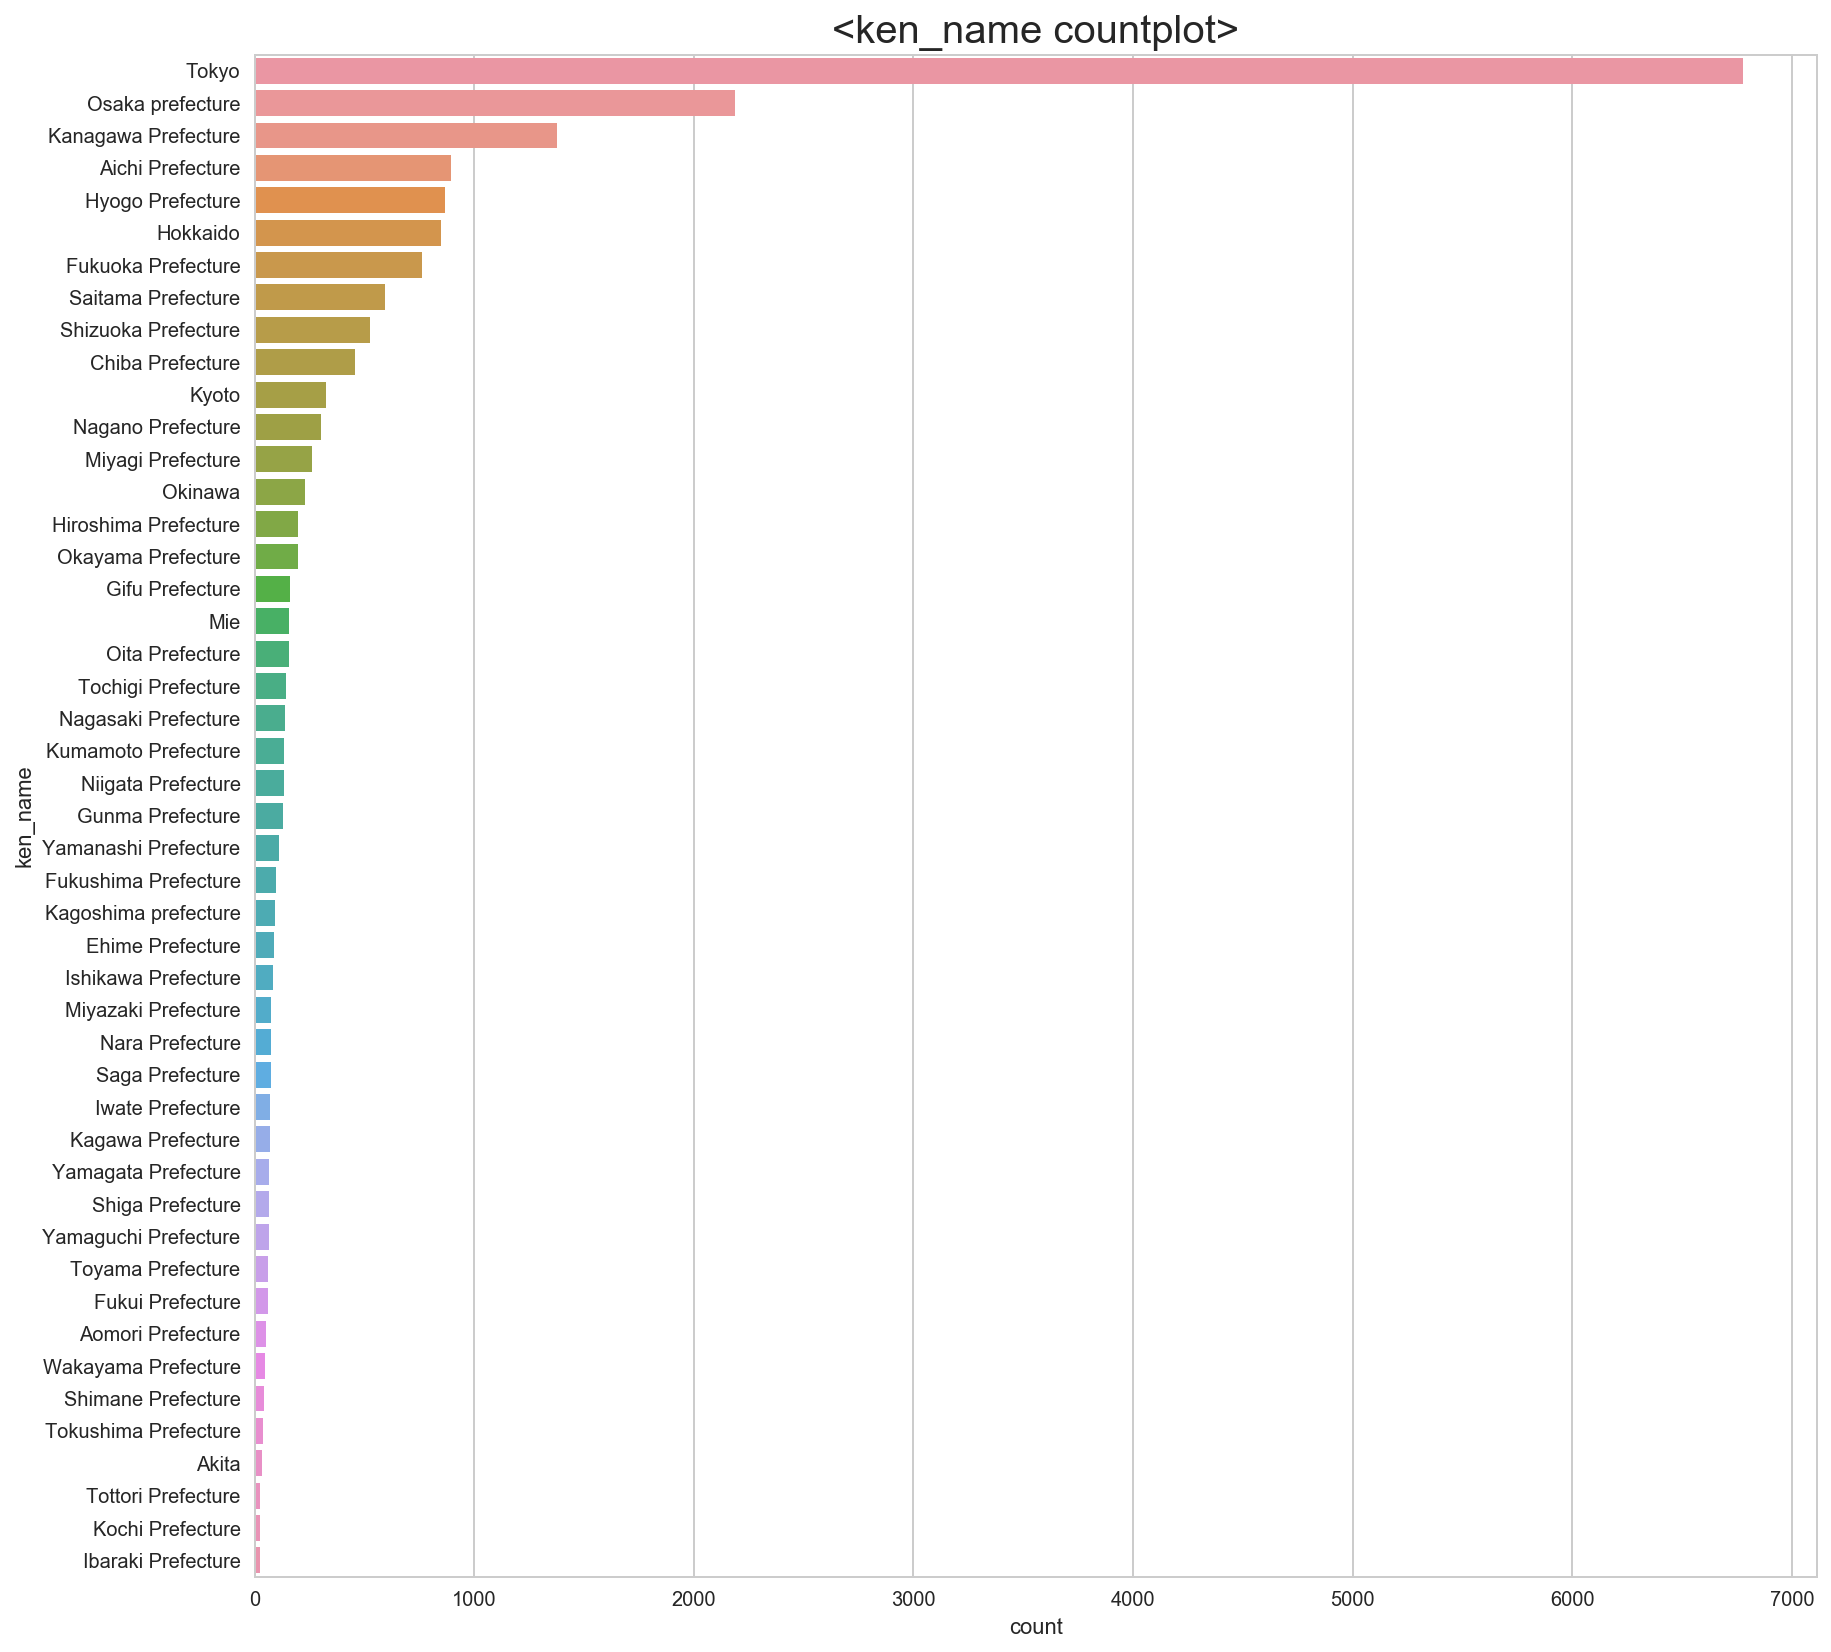

In [26]:
# ken_name countplot
plt.figure(figsize=(14, 14))
plt.title("<ken_name countplot>", fontsize = 20)
sns.countplot(y = coupon_list['ken_name'], data = coupon_list, order = coupon_list['ken_name'].value_counts().index)

plt.show()

#### 3.2.11 small_area_name

In [24]:
# small_area_name counts DataFrame
small_area_name = coupon_list.groupby("small_area_name").size().reset_index(name='counts')
small_area_name = small_area_name.sort_values(by=['counts'], ascending=False)
small_area_name = small_area_name.reset_index(drop=True)
small_area_name.head()

KeyError: 'small_area_name'

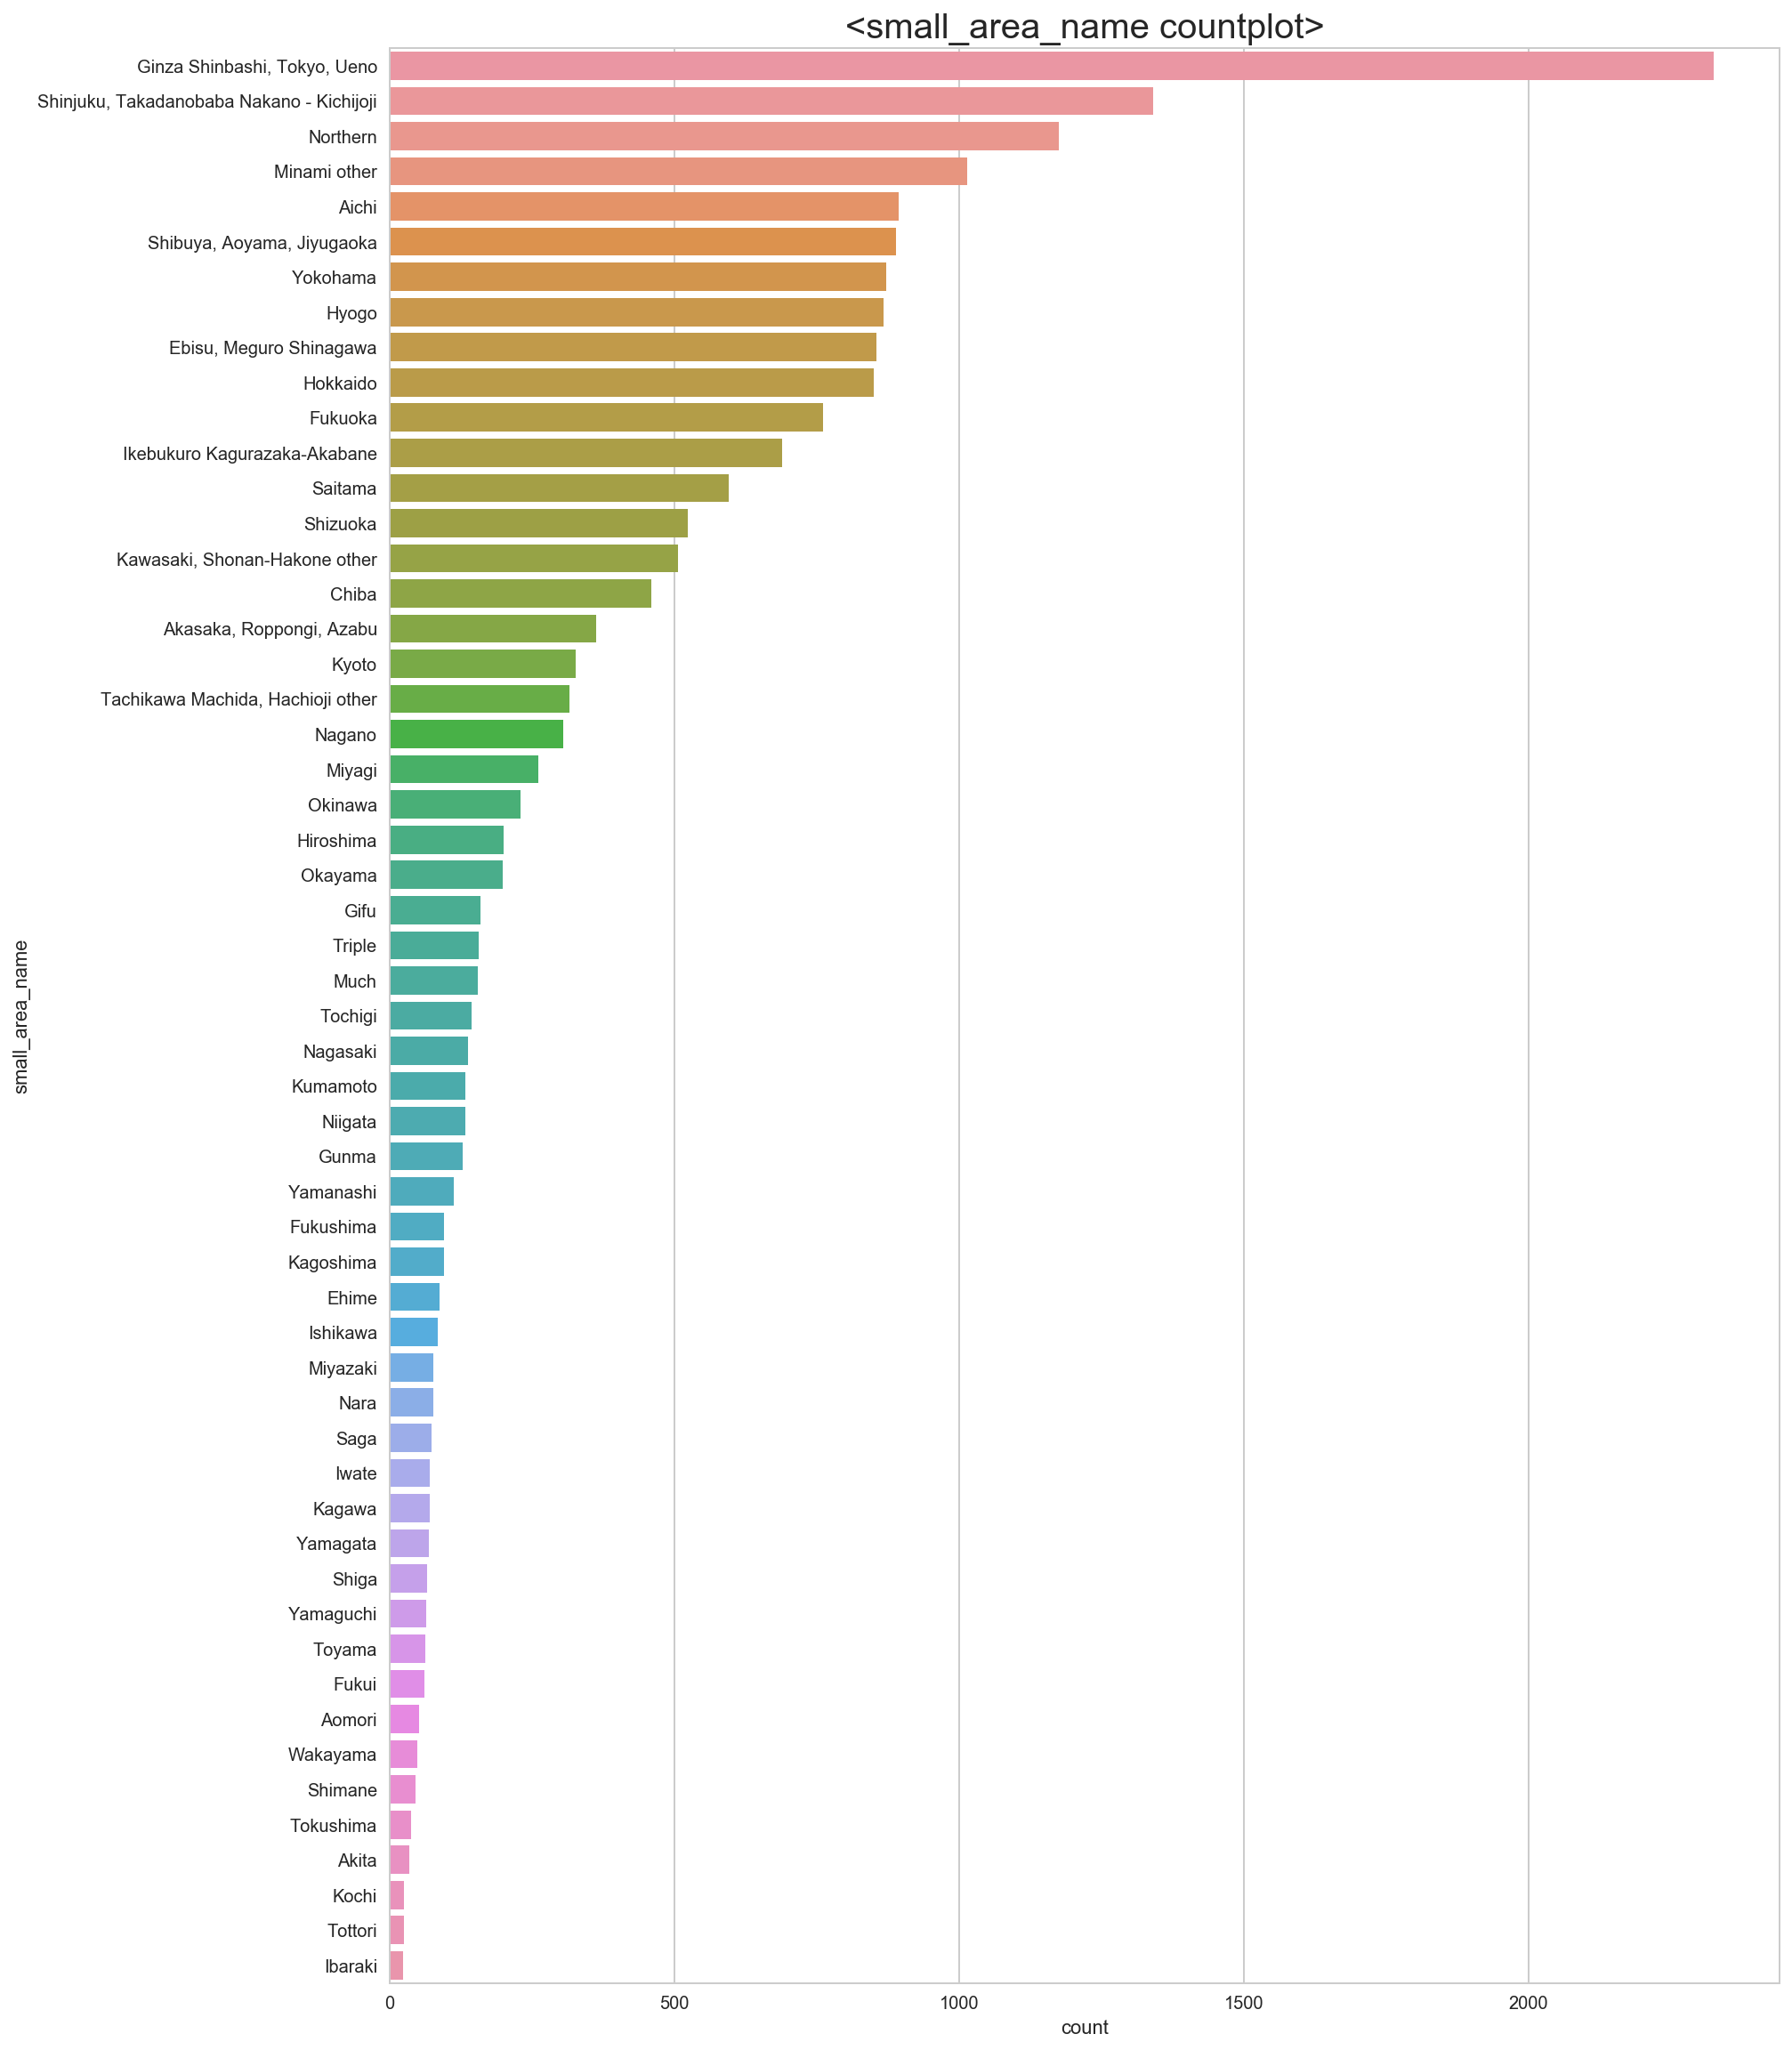

In [28]:
# ken_name countplot
plt.figure(figsize=(14, 20))
plt.title("<small_area_name countplot>", fontsize = 20)
sns.countplot(y = coupon_list['small_area_name'], data = coupon_list, order = coupon_list['small_area_name'].value_counts().index)

plt.show()

#### 3.2.12 NAN / Outlier 제거

In [29]:
# NAN
imp = Imputer(missing_values='NaN', strategy='mean', axis=0)
coupon_list['VALIDPERIOD'] = imp.fit_transform(coupon_list['VALIDPERIOD'].values.reshape(len(coupon_list),1))

# outlier 제거
coupon_list = coupon_list[coupon_list['PRICE_RATE'] > 20].reset_index(drop=True)
coupon_list = coupon_list[coupon_list['PRICE_RATE'] < 85].reset_index(drop=True)
coupon_list = coupon_list[coupon_list['DISCOUNT_PRICE'] < 20000].reset_index(drop=True)
coupon_list = coupon_list[coupon_list['DISPPERIOD'] < 8].reset_index(drop=True)

### 3.3 Coupon_visit / Coupon_purchase

- Coupon_visit : 유저가 어떤 쿠폰을 봤는지에 관한 정보
- Coupon_purchase : 유저가 어떤 쿠폰을 샀는지에 대한 정보

#### 3.3.1 Data_load

In [11]:
coupon_visit = pd.read_csv('../data/coupon_visit_train.csv')
coupon_purchase_train = pd.read_csv('../data/coupon_detail_train_translated_en.csv', index_col=0)

In [12]:
# shape
print("coupon_visit : ", coupon_visit.shape)
print("coupon_purchase : ", coupon_purchase_train.shape)

coupon_visit :  (2833180, 8)
coupon_purchase :  (168996, 5)


#### 3.3.2 Overall EDA

In [32]:
# information
coupon_visit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2833180 entries, 0 to 2833179
Data columns (total 8 columns):
PURCHASE_FLG           int64
I_DATE                 object
PAGE_SERIAL            int64
REFERRER_hash          object
VIEW_COUPON_ID_hash    object
USER_ID_hash           object
SESSION_ID_hash        object
PURCHASEID_hash        object
dtypes: int64(2), object(6)
memory usage: 172.9+ MB


In [33]:
# information
coupon_purchase_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 168996 entries, 0 to 168995
Data columns (total 6 columns):
ITEM_COUNT         168996 non-null int64
I_DATE             168996 non-null object
SMALL_AREA_NAME    168996 non-null object
PURCHASEID_hash    168996 non-null object
USER_ID_hash       168996 non-null object
COUPON_ID_hash     168996 non-null object
dtypes: int64(1), object(5)
memory usage: 9.0+ MB


In [34]:
# Unique count
for i in range(0, 7+1):
    print('{} : {}'.format(coupon_visit.columns[i], len(set(coupon_visit[coupon_visit.columns[i]]))))

PURCHASE_FLG : 2
I_DATE : 2638744
PAGE_SERIAL : 466
REFERRER_hash : 97319
VIEW_COUPON_ID_hash : 32628
USER_ID_hash : 22805
SESSION_ID_hash : 1046179
PURCHASEID_hash : 114775


#### 3.3.3 PURCHASE_FLG

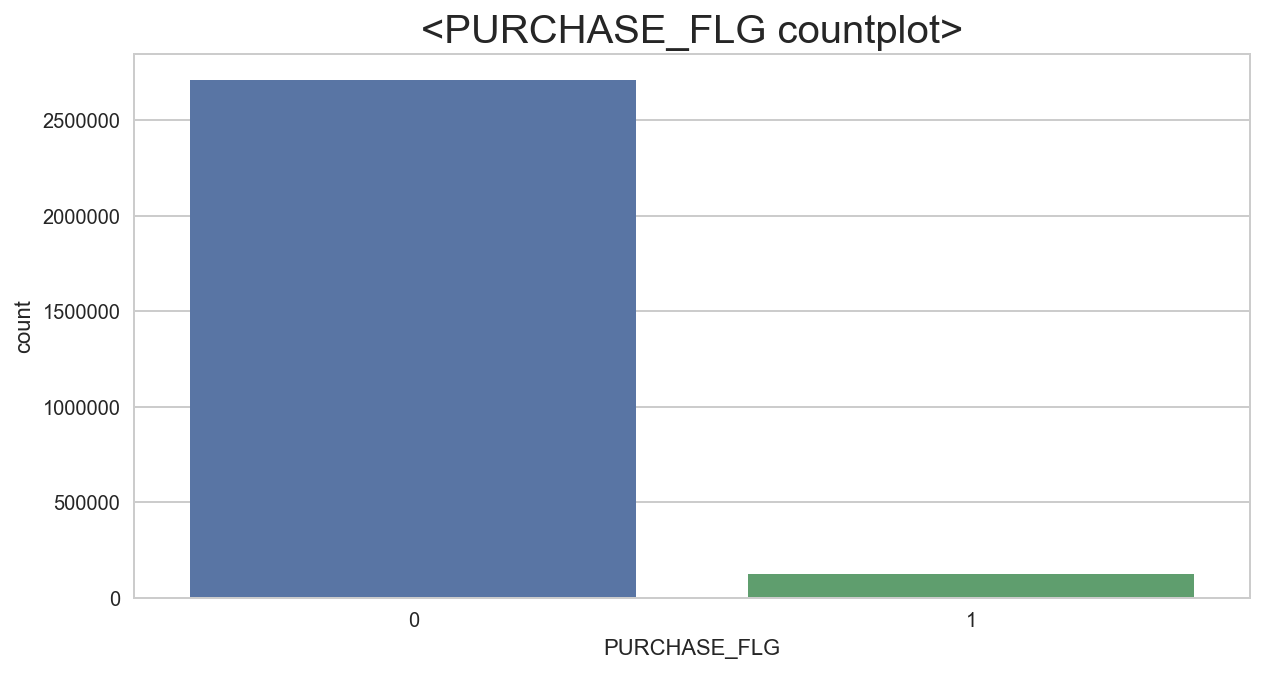

In [35]:
# PURCHASE_FLG countplot
plt.figure(figsize=(10, 5))
sns.countplot(x = coupon_visit['PURCHASE_FLG'], data = coupon_visit)
plt.title("<PURCHASE_FLG countplot>", fontsize = 20)

plt.show()

In [29]:
pur = coupon_visit['PURCHASE_FLG']
len(pur[pur==1]) / len(pur[pur==0])

0.04514881449731831

#### Note :

1. PURCHASE_FLG = 1이라면 Visit = Detail
2. 조회된 쿠폰 중 실제 구매된 구폰은 4%에 불과
3. y_train 값으로 선택

#### 3.3.4 USER_ID_hash

In [13]:
USER_ID = coupon_purchase_train.groupby("USER_ID_hash").size().reset_index(name='counts')
USER_ID = USER_ID.sort_values(by=['counts'], ascending=False)
USER_ID = USER_ID.reset_index(drop=True)
USER_ID.head(10)

,USER_ID_hash,counts
0,acd5e20541a5177e039835cef949d38d,101
1,01f61f5948da9c6c47bc47e6a959d48c,89
2,8a74bbcbdf2290988e92b4f0a52e57a7,87
3,e5ce4e00a1d90a6951940fea4acdd61b,86
4,e229db6f4d3554b8b96a8c04582b50eb,86
5,a52a3c977748da9f8329d963a1ea93b6,84
6,4c20177df5716ba57105ba5d9ed3c460,84
7,95450b42d18e10be665087b0da1e8728,83
8,b513d24721f5f8628c338a6271ab1154,81
9,06cbadc8825c72e0501eb22d08b1fe63,80


#### 3.3.4 USER_ID_hash

In [31]:
COUPON_ID = coupon_purchase_train.groupby("COUPON_ID_hash").size().reset_index(name='counts')
COUPON_ID = COUPON_ID.sort_values(by=['counts'], ascending=False)
COUPON_ID = COUPON_ID.reset_index(drop=True)
COUPON_ID.head(10)

,COUPON_ID_hash,counts
0,a262c7ff56a5cd3de3c5c40443f3018c,5760
1,3d9029d3ec66802b11ee2645dc16e8cb,1511
2,09411858ae07c0be91aeeddacf4556b4,1016
3,7fc6567f470af5356ae97097dbe18486,863
4,bf69bd9e0e26fa1f62243d1fcada38f1,663
5,047fb1f23d8cedea8cb86956cfd4b7cf,628
6,36addcc4b958135895c859d8783e3cd2,524
7,3e6d617c55328b761d62510167c43c08,504
8,229ff5cc21c8d26615493be7f3b42841,494
9,4a79cd05ecb2bf8672e1d955f5faa7fa,466


---

## 4. Modeling

### 4.1 Merge

#### 4.1.1 Merge 구조

DataFrame = [ User <-> View, Detail <-> Coupon ]

#### 4.1.2 Merge

In [14]:
coupon_list_train = coupon_list
coupon_list_test = pd.read_csv('../data/coupon_list_test_translated_en.csv')

In [15]:
# merge to obtain (USER_ID) <-> (COUPON_ID with features) training set
purchased_coupons_train = coupon_purchase_train.merge(coupon_list_train, on='COUPON_ID_hash', how='inner')
purchased_coupons_train = purchased_coupons_train.merge(user_list, on = 'USER_ID_hash', how = 'outer')

---

### 4.2 Feature_selection

In [16]:
purchased_coupons_train.columns

Index(['I_DATE', 'SMALL_AREA_NAME_x', 'PURCHASEID_hash', 'USER_ID_hash',
       'COUPON_ID_hash', 'GENRE_NAME', 'PRICE_RATE', 'CATALOG_PRICE',
       'DISCOUNT_PRICE', 'DISPFROM', 'DISPEND', 'DISPPERIOD', 'VALIDFROM',
       'VALIDEND', 'VALIDPERIOD', 'USABLE_DATE_MON', 'USABLE_DATE_TUE',
       'USABLE_DATE_WED', 'USABLE_DATE_THU', 'USABLE_DATE_FRI',
       'USABLE_DATE_SAT', 'USABLE_DATE_SUN', 'USABLE_DATE_HOLIDAY',
       'USABLE_DATE_BEFORE_HOLIDAY', 'LARGE_AREA_NAME', 'ken_name',
       'SMALL_AREA_NAME_y', 'SEX_ID', 'AGE', 'WITHDRAW_DATE', 'PREF_NAME'],
      dtype='object')

In [17]:
# filter redundant features
features = ['COUPON_ID_hash', 'USER_ID_hash', 'GENRE_NAME', 'DISCOUNT_PRICE','LARGE_AREA_NAME', 'ken_name', 'SMALL_AREA_NAME_x',]
purchased_coupons_train = purchased_coupons_train[features]

In [18]:
# create 'dummyuser' records in order to merge training and testing sets in one
coupon_list_test['USER_ID_hash'] = 'dummyuser'

In [19]:
coupon_list_test.rename(columns={'SMALL_AREA_NAME':'SMALL_AREA_NAME_x'},inplace=True)

In [20]:
coupon_list_test.columns

Index(['CAPSULE_TEXT', 'GENRE_NAME', 'PRICE_RATE', 'CATALOG_PRICE',
       'DISCOUNT_PRICE', 'DISPFROM', 'DISPEND', 'DISPPERIOD', 'VALIDFROM',
       'VALIDEND', 'VALIDPERIOD', 'USABLE_DATE_MON', 'USABLE_DATE_TUE',
       'USABLE_DATE_WED', 'USABLE_DATE_THU', 'USABLE_DATE_FRI',
       'USABLE_DATE_SAT', 'USABLE_DATE_SUN', 'USABLE_DATE_HOLIDAY',
       'USABLE_DATE_BEFORE_HOLIDAY', 'LARGE_AREA_NAME', 'ken_name',
       'SMALL_AREA_NAME_x', 'COUPON_ID_hash', 'USER_ID_hash'],
      dtype='object')

In [21]:
# filter testing set consistently with training set
coupon_list_test = coupon_list_test[features]

In [24]:
purchased_coupons_train.isnull().sum()

COUPON_ID_hash       91
USER_ID_hash          0
GENRE_NAME           91
DISCOUNT_PRICE       91
LARGE_AREA_NAME      91
ken_name             91
SMALL_AREA_NAME_x    91
dtype: int64

In [25]:
# merge sets together
combined = pd.concat([purchased_coupons_train, coupon_list_test], axis=0)

In [26]:
combined.isnull().sum()

COUPON_ID_hash       91
USER_ID_hash          0
GENRE_NAME           91
DISCOUNT_PRICE       91
LARGE_AREA_NAME      91
ken_name             91
SMALL_AREA_NAME_x    91
dtype: int64

In [27]:
# convert categoricals to OneHotEncoder form
categoricals = ['GENRE_NAME', 'LARGE_AREA_NAME', 'ken_name', 'SMALL_AREA_NAME_x',]
combined_categoricals = combined[categoricals]
combined_categoricals = pd.get_dummies(combined_categoricals, dummy_na=False)

In [32]:
combined.isnull().sum()

COUPON_ID_hash                                             0
USER_ID_hash                                               0
DISCOUNT_PRICE                                             0
GENRE_NAME_Beauty                                          0
GENRE_NAME_Delivery service                                0
GENRE_NAME_Food                                            0
GENRE_NAME_Gift card                                       0
GENRE_NAME_Hair salon                                      0
GENRE_NAME_Health and medical                              0
GENRE_NAME_Hotel and Japanese hotel                        0
GENRE_NAME_Leisure                                         0
GENRE_NAME_Lesson                                          0
GENRE_NAME_Nail and eye salon                              0
GENRE_NAME_Other coupon                                    0
GENRE_NAME_Relaxation                                      0
GENRE_NAME_Spa                                             0
LARGE_AREA_NAME_China   

In [28]:
# leaving continuous features as is, obtain transformed dataset
continuous = list(set(features) - set(categoricals))

In [29]:
combined = pd.concat([combined[continuous], combined_categoricals], axis=1)

In [31]:
# remove NaN values
NAN_SUBSTITUTION_VALUE = 1
combined = combined.fillna(NAN_SUBSTITUTION_VALUE)

In [52]:
# split back into training and testing sets
train = combined[combined['USER_ID_hash'] != 'dummyuser']
test = combined[combined['USER_ID_hash'] == 'dummyuser']
test2 = test.copy()
test2.drop('USER_ID_hash', inplace=True, axis=1)

In [53]:
# find most appropriate coupon for every user (mean of all purchased coupons), in other words, user profile
train_dropped_coupons = train.drop('COUPON_ID_hash', axis=1)
user_profiles = train_dropped_coupons.groupby(by='USER_ID_hash').mean()
test_only_features = test2.drop('COUPON_ID_hash', axis=1)

In [60]:
vector_1

,DISCOUNT_PRICE,GENRE_NAME_Beauty,GENRE_NAME_Delivery service,GENRE_NAME_Food,GENRE_NAME_Gift card,GENRE_NAME_Hair salon,GENRE_NAME_Health and medical,GENRE_NAME_Hotel and Japanese hotel,GENRE_NAME_Leisure,GENRE_NAME_Lesson,...,SMALL_AREA_NAME_x_Tochigi,SMALL_AREA_NAME_x_Tokushima,SMALL_AREA_NAME_x_Tottori,SMALL_AREA_NAME_x_Toyama,SMALL_AREA_NAME_x_Triple,SMALL_AREA_NAME_x_Wakayama,SMALL_AREA_NAME_x_Yamagata,SMALL_AREA_NAME_x_Yamaguchi,SMALL_AREA_NAME_x_Yamanashi,SMALL_AREA_NAME_x_Yokohama
USER_ID_hash,,,,,,,,,,,,,,,,,,,,,
0000b53e182165208887ba65c079fc21,0.164521,-0.041311,-0.945200,3.104752,-0.458103,-0.212575,-0.051567,-0.412347,-0.312359,-0.163288,...,-0.120371,-0.071848,-0.083524,-0.062527,-0.146845,-0.137038,-0.095661,-0.077396,-0.079776,-0.255570
00035b86e6884589ec8d28fbf2fe7757,-0.335620,-0.041311,-0.945200,3.104752,-0.458103,-0.212575,-0.051567,-0.412347,-0.312359,-0.163288,...,-0.120371,-0.071848,-0.083524,-0.062527,-0.146845,-0.137038,-0.095661,-0.077396,-0.079776,-0.255570
0005b1068d5f2b8f2a7c978fcfe1ca06,2.504107,-0.041311,-0.945200,-0.581985,2.089824,-0.212575,-0.051567,-0.412347,-0.312359,4.237274,...,-0.120371,-0.071848,-0.083524,-0.062527,-0.146845,-0.137038,-0.095661,-0.077396,-0.079776,-0.255570
000cc06982785a19e2a2fdb40b1c9d59,-0.366709,-0.041311,-0.000180,-0.055308,0.997856,0.628112,-0.051567,-0.412347,-0.312359,-0.163288,...,-0.120371,-0.071848,-0.083524,-0.062527,-0.146845,0.654681,-0.095661,-0.077396,-0.079776,-0.255570
0013518e41c416cd6a181d277dd8ca0b,0.624382,-0.041311,-0.945200,-0.581985,-0.458103,-0.212575,-0.051567,0.718002,1.126238,-0.163288,...,-0.120371,-0.071848,-0.083524,-0.062527,-0.146845,-0.137038,-0.095661,-0.077396,-0.079776,1.478838
001acdee812a18acfd7509172bed5700,-0.382872,-0.041311,1.017534,-0.581985,-0.066114,0.466442,-0.051567,-0.412347,0.130286,-0.163288,...,-0.120371,-0.071848,-0.083524,-0.062527,-0.146845,-0.137038,-0.095661,-0.077396,-0.079776,-0.255570
001fd7876e3aa29393537c6baf308e43,-0.234921,-0.041311,1.889860,-0.581985,-0.458103,-0.212575,-0.051567,-0.412347,-0.312359,-0.163288,...,-0.120371,-0.071848,-0.083524,-0.062527,-0.146845,-0.137038,-0.095661,-0.077396,-0.079776,-0.255570
002383753c1e5d6305c8aff6f89e26d6,-0.500096,-0.041311,-0.945200,3.104752,-0.458103,-0.212575,-0.051567,-0.412347,-0.312359,-0.163288,...,-0.120371,-0.071848,-0.083524,-0.062527,-0.146845,-0.137038,-0.095661,-0.077396,-0.079776,-0.255570
0025cae7997d25ea5cf8851bb099c798,-0.106249,-0.041311,-0.945200,1.875840,-0.458103,0.768227,-0.051567,-0.412347,-0.312359,-0.163288,...,-0.120371,-0.071848,-0.083524,-0.062527,-0.146845,-0.137038,-0.095661,-0.077396,-0.079776,0.515278


In [62]:
list(vector_1.columns)

['DISCOUNT_PRICE',
 'GENRE_NAME_Beauty',
 'GENRE_NAME_Delivery service',
 'GENRE_NAME_Food',
 'GENRE_NAME_Gift card',
 'GENRE_NAME_Hair salon',
 'GENRE_NAME_Health and medical',
 'GENRE_NAME_Hotel and Japanese hotel',
 'GENRE_NAME_Leisure',
 'GENRE_NAME_Lesson',
 'GENRE_NAME_Nail and eye salon',
 'GENRE_NAME_Other coupon',
 'GENRE_NAME_Relaxation',
 'GENRE_NAME_Spa',
 'LARGE_AREA_NAME_China',
 'LARGE_AREA_NAME_EastSea',
 'LARGE_AREA_NAME_Hokkaido',
 'LARGE_AREA_NAME_Hokushinetsu',
 'LARGE_AREA_NAME_Kansai',
 'LARGE_AREA_NAME_Kanto',
 'LARGE_AREA_NAME_Kyushu-Okinawa',
 'LARGE_AREA_NAME_Northeast',
 'LARGE_AREA_NAME_Shikoku',
 'ken_name_Aichi',
 'ken_name_Akita',
 'ken_name_Aomori',
 'ken_name_Chiba',
 'ken_name_Ehime',
 'ken_name_Fukui',
 'ken_name_Fukuoka',
 'ken_name_Fukushima',
 'ken_name_Gifu',
 'ken_name_Gunma',
 'ken_name_Hiroshima',
 'ken_name_Hokkaido',
 'ken_name_Hyogo',
 'ken_name_Ibaraki',
 'ken_name_Ishikawa',
 'ken_name_Iwate',
 'ken_name_Kagawa',
 'ken_name_Kagoshima',
 'k

In [64]:
list(vector_2.columns)

['DISCOUNT_PRICE',
 'GENRE_NAME_Beauty',
 'GENRE_NAME_Delivery service',
 'GENRE_NAME_Food',
 'GENRE_NAME_Gift card',
 'GENRE_NAME_Hair salon',
 'GENRE_NAME_Health and medical',
 'GENRE_NAME_Hotel and Japanese hotel',
 'GENRE_NAME_Leisure',
 'GENRE_NAME_Lesson',
 'GENRE_NAME_Nail and eye salon',
 'GENRE_NAME_Other coupon',
 'GENRE_NAME_Relaxation',
 'GENRE_NAME_Spa',
 'LARGE_AREA_NAME_China',
 'LARGE_AREA_NAME_EastSea',
 'LARGE_AREA_NAME_Hokkaido',
 'LARGE_AREA_NAME_Hokushinetsu',
 'LARGE_AREA_NAME_Kansai',
 'LARGE_AREA_NAME_Kanto',
 'LARGE_AREA_NAME_Kyushu-Okinawa',
 'LARGE_AREA_NAME_Northeast',
 'LARGE_AREA_NAME_Shikoku',
 'ken_name_Aichi',
 'ken_name_Akita',
 'ken_name_Aomori',
 'ken_name_Chiba',
 'ken_name_Ehime',
 'ken_name_Fukui',
 'ken_name_Fukuoka',
 'ken_name_Fukushima',
 'ken_name_Gifu',
 'ken_name_Gunma',
 'ken_name_Hiroshima',
 'ken_name_Hokkaido',
 'ken_name_Hyogo',
 'ken_name_Ibaraki',
 'ken_name_Ishikawa',
 'ken_name_Iwate',
 'ken_name_Kagawa',
 'ken_name_Kagoshima',
 'k

In [57]:
# scaling 실험

from sklearn.preprocessing import scale, robust_scale, minmax_scale, maxabs_scale

vector_1 = user_profiles.copy()
vector_2 = test_only_features.copy()

vector_1 = scale(vector_1)
vector_1 = pd.DataFrame(data = vector_1, index = user_profiles.index, columns = user_profiles.columns )

vector_2 = scale(vector_2)
vector_2 = pd.DataFrame(data = vector_2, index = test_only_features.index, columns = test_only_features.columns )



In [54]:
from scipy import spatial
def cosine_similarity(vector_1, vector_2):

    return 1 - spatial.distance.cosine(vector_1, vector_2) 

In [ ]:
matrix = []
for idx1 in range(len(user_profiles)):
    row = []
    for idx2 in range(len(test_only_features)):
        row.append(cosine_similarity(vector_1.iloc[idx1], vector_2.iloc[idx2]))
    matrix.append(row)

In [ ]:
coupons_ids = test['COUPON_ID_hash']
result_index = vector_1.index
result_columns = [coupons_ids[i] for i in range(0, 310)]
result_df = pd.DataFrame(index= result_index, columns=result_columns, data=matrix)

In [ ]:
submission = pd.DataFrame(columns=['USER_ID_hash','PURCHASED_COUPONS'])
submission['USER_ID_hash'] = result_df.index
submission['PURCHASED_COUPONS'] = result_df.T.apply(lambda x: " ".join(x.sort_values(ascending=False)[:21].index)).values

In [ ]:
from datetime import datetime
now = datetime.now()
cur_time = now.strftime('%Y-%m-%d %H-%M-%S')

submission.to_csv('submission/cosine'+cur_time+'.csv',index = False,header=True)